In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
crunchbase = os.path.join(os.getcwd(), "crunchbase-investments.csv")
df = pd.read_csv(crunchbase, encoding='latin1')
df = df.head(1000)

<ipython-input-54-cd27ff7b212f>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(crunchbase, encoding='latin1')


In [ ]:
df['investor_name'].nunique()
df.shape

(1000, 20)

In [ ]:
# Step 1: Filter investors with fewer than 4 investments
investor_counts = df.groupby('investor_name').size().reset_index(name='investment_count')
filtered_investors = investor_counts[investor_counts['investment_count'] > 4]
df = df[df['investor_name'].isin(filtered_investors['investor_name'])]

# Step 2: Drop irrelevant columns
drop_cols = ['company_permalink', 'investor_permalink']
existing_cols = [col for col in drop_cols if col in df.columns]
df = df.drop(existing_cols, axis=1)

# Step 3: Handle missing values in 'company_category_code'
most_common_category = df['company_category_code'].mode()[0]
df['company_category_code'].fillna(most_common_category, inplace=True)

# map investor to integer + standardize / normalize
# Step 4: Encode investors and companies as integers
investor_encoder = LabelEncoder()
company_encoder = LabelEncoder()
df['investor_id'] = investor_encoder.fit_transform(df['investor_name'])
df['company_id'] = company_encoder.fit_transform(df['company_name'])

# Step 5: Define the target variable
df['interaction'] = 1  # Every row represents an interaction

df['interaction_weight'] = df['raised_amount_usd'].fillna(0)


print(df['investor_name'].value_counts())  # Check interaction counts per investor
print(df['company_name'].value_counts())  # Check interaction counts per company

def safe_transform(encoder, value):
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        print(f"Warning: {value} is not in the encoder's classes.")
        return None  # Or handle as needed (e.g., return a default value)

# Collect necessary statistics for imputation
stats = {
    'company_category_code': df['company_category_code'].mode()[0],
    'company_country_code': df['company_country_code'].mode()[0],
    'company_state_code': df['company_state_code'].mode()[0],
    'company_region': df['company_region'].mode()[0],
    'company_city': df['company_city'].mode()[0],
    'investor_category_code': df['investor_category_code'].mode()[0],
    'investor_country_code': df['investor_country_code'].mode()[0],
    'investor_state_code': df['investor_state_code'].mode()[0],
    'investor_region': df['investor_region'].mode()[0],
    'investor_city': df['investor_city'].mode()[0],
    'funding_round_type': df['funding_round_type'].mode()[0],
    'raised_amount_usd': df['raised_amount_usd'].median(),
    'funded_at': df['funded_at'].mode()[0],
    'funded_month': df['funded_month'].mode()[0],
    'funded_quarter': df['funded_quarter'].mode()[0],
    'funded_year': df['funded_year'].mode()[0],
    'interaction_weight': 0  # Default for negative samples
}

# Function to assign random values from existing data
def random_from_existing(column_name, size):
    return np.random.choice(df[column_name].dropna().unique(), size=size)

# Generate negative samples and append directly to df
all_investors = df['investor_id'].unique()
all_companies = df['company_id'].unique()
existing_pairs = set(zip(df['investor_id'], df['company_id']))

# Ensure mapping dictionaries for investor_id -> investor_name and company_id -> company_name
investor_id_to_name = dict(zip(df['investor_id'], df['investor_name']))
company_id_to_name = dict(zip(df['company_id'], df['company_name']))

# Generate negative samples and ensure name mappings
negative_samples = []
while len(negative_samples) < len(df[df['interaction'] == 1]):  # Balance with positive interactions
    investor = np.random.choice(all_investors)
    company = np.random.choice(all_companies)
    if (investor, company) not in existing_pairs:  # Avoid duplicates
        negative_samples.append({
            'investor_id': investor,
            'company_id': company,
            'investor_name': investor_id_to_name.get(investor, "Unknown"),  # Map or use "Unknown"
            'company_name': company_id_to_name.get(company, "Unknown"),    # Map or use "Unknown"
            'interaction': 0,
            'interaction_weight': stats['interaction_weight'],
            'company_category_code': random_from_existing('company_category_code', 1)[0],
            'company_country_code': random_from_existing('company_country_code', 1)[0],
            'company_state_code': random_from_existing('company_state_code', 1)[0],
            'company_region': random_from_existing('company_region', 1)[0],
            'company_city': random_from_existing('company_city', 1)[0],
            'investor_category_code': random_from_existing('investor_category_code', 1)[0],
            'investor_country_code': random_from_existing('investor_country_code', 1)[0],
            'investor_state_code': random_from_existing('investor_state_code', 1)[0],
            'investor_region': random_from_existing('investor_region', 1)[0],
            'investor_city': random_from_existing('investor_city', 1)[0],
            'funding_round_type': random_from_existing('funding_round_type', 1)[0],
            'raised_amount_usd': stats['raised_amount_usd'],
            'funded_at': stats['funded_at'],
            'funded_month': stats['funded_month'],
            'funded_quarter': stats['funded_quarter'],
            'funded_year': stats['funded_year']
        })

# Convert the list of negative samples into a DataFrame
negative_df = pd.DataFrame(negative_samples)

# Concatenate negative samples with the original dataset
df = pd.concat([df, negative_df], ignore_index=True)

# Validate the updated dataframe
print(df.info())  # Check non-null counts
print(df['interaction'].value_counts())  # Validate interaction balance


# Display the first few rows of the new dataset
print(df.head(10))


<ipython-input-56-f2ea663f7360>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['company_category_code'].fillna(most_common_category, inplace=True)


investor_name
betaworks                               80
Cisco                                   67
Betaspring                              41
Entrepreneurs Roundtable Accelerator    38
Amgen                                   25
AngelPad                                24
Amazon                                  24
Excelerate Labs                         22
American Express                        15
eBay                                    13
Citrix Systems                          12
AT&T                                    11
Comcast                                  9
BoxGroup                                 9
Boston Scientific                        8
Celgene                                  7
Concur Technologies                      7
10Xelerator                              7
Archimedes Labs                          7
Arch Grants                              7
Advance Publications                     7
Bertelsmann                              6
DG Incubation                           

In [ ]:
print(df.info())
print(df['interaction'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_name            1020 non-null   object 
 1   company_category_code   1020 non-null   object 
 2   company_country_code    1020 non-null   object 
 3   company_state_code      1017 non-null   object 
 4   company_region          1020 non-null   object 
 5   company_city            1014 non-null   object 
 6   investor_name           1020 non-null   object 
 7   investor_category_code  958 non-null    object 
 8   investor_country_code   1009 non-null   object 
 9   investor_state_code     988 non-null    object 
 10  investor_region         1020 non-null   object 
 11  investor_city           994 non-null    object 
 12  funding_round_type      1020 non-null   object 
 13  funded_at               1020 non-null   object 
 14  funded_month            1020 non-null   

In [ ]:
stats = {
    'company_category_code': df['company_category_code'].mode()[0],  # Mode for categorical
    'company_country_code': df['company_country_code'].mode()[0],
    'company_state_code': df['company_state_code'].mode()[0],
    'company_region': df['company_region'].mode()[0],
    'company_city': df['company_city'].mode()[0],
    'investor_category_code': df['investor_category_code'].mode()[0],
    'investor_country_code': df['investor_country_code'].mode()[0],
    'investor_state_code': df['investor_state_code'].mode()[0],
    'investor_region': df['investor_region'].mode()[0],
    'investor_city': df['investor_city'].mode()[0],
    'funding_round_type': df['funding_round_type'].mode()[0],
    'raised_amount_usd': df['raised_amount_usd'].median(),  # Median for numerical
    'funded_at': df['funded_at'].mode()[0],  # Date as mode or a random valid date
    'funded_month': df['funded_month'].mode()[0],
    'funded_quarter': df['funded_quarter'].mode()[0],
    'funded_year': df['funded_year'].mode()[0],
    'interaction_weight': 0  # Set interaction weight to 0 for negative samples
}

# Function to assign random categorical values for certain columns
def random_from_existing(column_name, size):
    return np.random.choice(df[column_name].dropna().unique(), size=size)

# Impute each column in the negative samples dataframe
negative_df['company_category_code'] = random_from_existing('company_category_code', len(negative_df))
negative_df['company_country_code'] = random_from_existing('company_country_code', len(negative_df))
negative_df['company_state_code'] = random_from_existing('company_state_code', len(negative_df))
negative_df['company_region'] = random_from_existing('company_region', len(negative_df))
negative_df['company_city'] = random_from_existing('company_city', len(negative_df))
negative_df['investor_category_code'] = random_from_existing('investor_category_code', len(negative_df))
negative_df['investor_country_code'] = random_from_existing('investor_country_code', len(negative_df))
negative_df['investor_state_code'] = random_from_existing('investor_state_code', len(negative_df))
negative_df['investor_region'] = random_from_existing('investor_region', len(negative_df))
negative_df['investor_city'] = random_from_existing('investor_city', len(negative_df))
negative_df['funding_round_type'] = random_from_existing('funding_round_type', len(negative_df))

# Impute numerical features
negative_df['raised_amount_usd'] = stats['raised_amount_usd']

# Impute date-related features
negative_df['funded_at'] = stats['funded_at']
negative_df['funded_month'] = stats['funded_month']
negative_df['funded_quarter'] = stats['funded_quarter']
negative_df['funded_year'] = stats['funded_year']

# Assign default values for interaction weight and interaction
negative_df['interaction_weight'] = stats['interaction_weight']
negative_df['interaction'] = 0  # Negative interactions

# Concatenate negative samples with original dataset
df = pd.concat([df, negative_df], ignore_index=True)

# Validate the resulting dataframe
print(df.info())
print(df['interaction'].value_counts())  # Check balance of positive and negative samples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_name            1530 non-null   object 
 1   company_category_code   1530 non-null   object 
 2   company_country_code    1530 non-null   object 
 3   company_state_code      1527 non-null   object 
 4   company_region          1530 non-null   object 
 5   company_city            1524 non-null   object 
 6   investor_name           1530 non-null   object 
 7   investor_category_code  1468 non-null   object 
 8   investor_country_code   1519 non-null   object 
 9   investor_state_code     1498 non-null   object 
 10  investor_region         1530 non-null   object 
 11  investor_city           1504 non-null   object 
 12  funding_round_type      1530 non-null   object 
 13  funded_at               1530 non-null   object 
 14  funded_month            1530 non-null   

In [ ]:
# Function to assign random values for columns in negative samples
def random_from_existing(column_name, size):
    return np.random.choice(df[column_name].dropna().unique(), size=size)

# Generate negative samples
negative_samples = []
for _ in range(len(df)):  # Balance positive and negative samples
    investor = np.random.choice(df['investor_id'].unique())
    company = np.random.choice(df['company_id'].unique())
    negative_samples.append({
        'investor_id': investor,
        'company_id': company,
        'interaction': 0,  # Negative interaction
        'interaction_weight': 0,  # Default weight
    })

# Convert to DataFrame
negative_df = pd.DataFrame(negative_samples)

# Impute all necessary columns in negative samples
columns_to_impute = [
    'company_name', 'company_category_code', 'company_country_code', 'company_state_code',
    'company_region', 'company_city', 'investor_name', 'investor_category_code',
    'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city',
    'funding_round_type', 'funded_at', 'funded_month', 'funded_quarter', 'funded_year',
    'raised_amount_usd'
]

for column in columns_to_impute:
    negative_df[column] = random_from_existing(column, len(negative_df))

# Handle missing values in numerical columns
negative_df['raised_amount_usd'].fillna(stats['raised_amount_usd'], inplace=True)
negative_df['funded_year'].fillna(stats['funded_year'], inplace=True)

# Check and remove duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
negative_df = negative_df.loc[:, ~negative_df.columns.duplicated()]

# Ensure column alignment between df and negative_df
negative_df = negative_df[df.columns]

# Concatenate negative samples with original dataset
df = pd.concat([df, negative_df], ignore_index=True)

# Verify the resulting dataset
print("Dataset after concatenation:")
print(df.info())
print("Interaction value counts:")
print(df['interaction'].value_counts())

# Concatenate negative samples with original dataset
df = pd.concat([df, negative_df], ignore_index=True)

# Verify the new dataset
print("Dataset after fixing null values:")
print(df.info())
print(df['interaction'].value_counts())  # Check balance of positive and negative samples


Dataset after concatenation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_name            3060 non-null   object 
 1   company_category_code   3060 non-null   object 
 2   company_country_code    3060 non-null   object 
 3   company_state_code      3057 non-null   object 
 4   company_region          3060 non-null   object 
 5   company_city            3054 non-null   object 
 6   investor_name           3060 non-null   object 
 7   investor_category_code  2998 non-null   object 
 8   investor_country_code   3049 non-null   object 
 9   investor_state_code     3028 non-null   object 
 10  investor_region         3060 non-null   object 
 11  investor_city           3034 non-null   object 
 12  funding_round_type      3060 non-null   object 
 13  funded_at               3060 non-null   object 
 14  funded_mont

<ipython-input-59-16911fbfe87b>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  negative_df['raised_amount_usd'].fillna(stats['raised_amount_usd'], inplace=True)
<ipython-input-59-16911fbfe87b>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

In [ ]:
# Train-test split -> Splits the data into training (80%) and testing (20%) sets.
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Define the maximum number of investors and companies (total num of unique)
# This is the size of the embedding layers in the neural network
num_investors = df['investor_id'].nunique()
num_companies = df['company_id'].nunique()

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Normalize funding amount
scaler = StandardScaler()
df['normalized_raised_amount'] = scaler.fit_transform(df[['raised_amount_usd']].fillna(0))

# Encode string features (like company_category_code, funding_round_type)
string_features = [
    'investor_category_code', 'investor_country_code', 'investor_state_code',
    'investor_region', 'investor_city', 'funding_round_type',
    'funded_month', 'funded_quarter', 'funded_year'
]

# Label encode each string feature and store in the dataset
encoded_string_features = {}
for feature in string_features:
    encoder = LabelEncoder()
    df[feature + '_encoded'] = encoder.fit_transform(df[feature].astype(str))
    encoded_string_features[feature] = encoder

# Prepare feature matrix for contextual features
context_features_columns = [f"{feature}_encoded" for feature in string_features] + ['normalized_raised_amount']
context_features = df[context_features_columns]

# Combine the contextual features with investor_id and company_id
X_train_context = [train['investor_id'], train['company_id'], context_features.loc[train.index].values]
X_test_context = [test['investor_id'], test['company_id'], context_features.loc[test.index].values]
y_train = train['interaction']
y_test = test['interaction']

# Verify the new dataset
print("Contextual features included in training data:")
print(context_features.head())


# encode string features !!

# Combine the engineered features with the dataset
df = pd.concat([df, context_features], axis=1)


df.head()

Contextual features included in training data:
   investor_category_code_encoded  investor_country_code_encoded  \
0                               4                              1   
1                               4                              1   
2                               4                              1   
3                               4                              1   
4                               4                              1   

   investor_state_code_encoded  investor_region_encoded  \
0                            9                        2   
1                            9                        2   
2                            9                        2   
3                            9                        2   
4                            9                        2   

   investor_city_encoded  funding_round_type_encoded  funded_month_encoded  \
0                      1                           1                    83   
1                      1         

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_category_code,investor_country_code,investor_state_code,...,investor_category_code_encoded,investor_country_code_encoded,investor_state_code_encoded,investor_region_encoded,investor_city_encoded,funding_round_type_encoded,funded_month_encoded,funded_quarter_encoded,funded_year_encoded,normalized_raised_amount
0,LaunchGram,news,USA,CA,SF Bay,Mountain View,10Xelerator,finance,USA,OH,...,4,1,9,2,1,1,83,36,12,-0.170763
1,uTaP,messaging,USA,NaN,United States - Other,NaN,10Xelerator,finance,USA,OH,...,4,1,9,2,1,1,83,36,12,-0.170763
2,ZoopShop,software,USA,OH,Columbus,columbus,10Xelerator,finance,USA,OH,...,4,1,9,2,1,0,84,36,12,-0.170763
3,eFuneral,web,USA,OH,Cleveland,Cleveland,10Xelerator,finance,USA,OH,...,4,1,9,2,1,1,79,34,11,-0.170763
4,Tackk,web,USA,OH,Cleveland,Cleveland,10Xelerator,finance,USA,OH,...,4,1,9,2,1,1,84,36,12,-0.170763


In [ ]:
df.columns

Index(['company_name', 'company_category_code', 'company_country_code',
       'company_state_code', 'company_region', 'company_city', 'investor_name',
       'investor_category_code', 'investor_country_code',
       'investor_state_code', 'investor_region', 'investor_city',
       'funding_round_type', 'funded_at', 'funded_month', 'funded_quarter',
       'funded_year', 'raised_amount_usd', 'investor_id', 'company_id',
       'interaction', 'interaction_weight', 'normalized_raised_amount',
       'investor_category_code_encoded', 'investor_country_code_encoded',
       'investor_state_code_encoded', 'investor_region_encoded',
       'investor_city_encoded', 'funding_round_type_encoded',
       'funded_month_encoded', 'funded_quarter_encoded', 'funded_year_encoded',
       'investor_category_code_encoded', 'investor_country_code_encoded',
       'investor_state_code_encoded', 'investor_region_encoded',
       'investor_city_encoded', 'funding_round_type_encoded',
       'funded_month_e

In [ ]:
import numpy as np
import pandas as pd

def prepare_training_data(df, context_features_columns):
    """
    Prepare training data for the ranking model from a DataFrame.

    Parameters:
    df: pandas DataFrame containing:
        - investor_id: ID of the investor
        - company_id: ID of the company
        - context features columns
        - target: 1 for positive pairs, 0 for negative pairs
    context_features_columns: list of column names for context features

    Returns:
    X_train: tuple of (investor_ids, company_ids, context_features)
    y_train: target labels
    """
    # Extract inputs
    X_train = (
        df['investor_id'].values,  # investor IDs
        df['company_id'].values,   # company IDs
        df[context_features_columns].values  # context features
    )

    # Extract target variable
    y_train = df['target'].values

    return X_train, y_train

"\ndf = pd.DataFrame({\n    'investor_id': [1, 1, 2, 2],\n    'company_id': [1, 2, 1, 3],\n    'revenue': [1000000, 2000000, 1500000, 3000000],\n    'employees': [50, 100, 75, 150],\n    'funding_stage': [2, 3, 2, 4],\n    'target': [1, 0, 1, 0]\n})\n\ncontext_features_columns = ['revenue', 'employees', 'funding_stage']\n\n# Prepare training and test data\nX_train, y_train = prepare_training_data(train_df, context_features_columns)\nX_test, y_test = prepare_training_data(test_df, context_features_columns)\n\n# Now you can train the model\nhistory = model.fit(\n    X_train, y_train,\n    epochs=10,\n    batch_size=64,\n    validation_data=(X_test, y_test),\n    verbose=1\n)\n"

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np

def create_enhanced_ranking_model(num_investors, num_companies, context_features_columns):
    # Inputs
    investor_input = Input(shape=(1,), name="Investor_Input")
    company_input = Input(shape=(1,), name="Company_Input")
    context_input = Input(shape=(len(context_features_columns),), name="Context_Input")

    # Normalize context features
    context_normalized = LayerNormalization()(context_input)

    # Enhanced embeddings
    investor_embedding = Embedding(
        input_dim=num_investors,
        output_dim=256,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
        name="Investor_Embedding"
    )(investor_input)

    company_embedding = Embedding(
        input_dim=num_companies,
        output_dim=256,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
        name="Company_Embedding"
    )(company_input)

    # Flatten embeddings
    investor_flat = Flatten()(investor_embedding)
    company_flat = Flatten()(company_embedding)

    # Process context features
    context_dense = Dense(128, activation="relu")(context_normalized)
    context_dense = BatchNormalization()(context_dense)
    context_dense = Dense(256, activation="relu")(context_dense)
    context_dense = BatchNormalization()(context_dense)

    # Process investor and company features
    investor_dense = Dense(256, activation="relu")(investor_flat)
    investor_dense = LayerNormalization()(investor_dense)

    company_dense = Dense(256, activation="relu")(company_flat)
    company_dense = LayerNormalization()(company_dense)

    # Enhanced feature interactions
    mult_interaction = tf.multiply(investor_dense, company_dense)
    add_interaction = tf.add(investor_dense, company_dense)

    # Concatenate all features
    concat = Concatenate()([
        investor_dense,
        company_dense,
        context_dense,
        mult_interaction,
        add_interaction
    ])

    # Multi-tower architecture for better feature learning
    tower1 = Dense(256, activation="relu")(concat)
    tower1 = BatchNormalization()(tower1)
    tower1 = Dense(128, activation="relu")(tower1)

    tower2 = Dense(256, activation="relu")(concat)
    tower2 = BatchNormalization()(tower2)
    tower2 = Dense(128, activation="relu")(tower2)

    # Combine towers
    combined = Concatenate()([tower1, tower2])
    x = Dense(256, activation="relu")(combined)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)

    # Output
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[investor_input, company_input, context_input], outputs=output)

    def focal_loss(gamma=2.0, alpha=0.75):
        def focal_loss_fixed(y_true, y_pred):
            # Focal loss for better handling of hard examples
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

            # Add small epsilon for numerical stability
            epsilon = K.epsilon()
            pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
            pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

            # Calculate focal loss
            loss = -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                   -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
            return loss
        return focal_loss_fixed

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=focal_loss(gamma=2.0, alpha=0.75),  # Higher alpha for positive class
        metrics=['accuracy']
    )

    return model

def generate_balanced_batches(X_train, y_train, batch_size=64):
    """
    Generate balanced batches with emphasis on positive examples
    """
    investor_input, company_input, context_input = X_train
    positive_indices = np.where(y_train == 1)[0]
    negative_indices = np.where(y_train == 0)[0]

    while True:
        # Sample with higher proportion of positives
        pos_size = int(batch_size * 0.5)  # 50% positive examples
        neg_size = batch_size - pos_size

        pos_idx = np.random.choice(positive_indices, pos_size, replace=True)
        neg_idx = np.random.choice(negative_indices, neg_size, replace=True)

        batch_indices = np.concatenate([pos_idx, neg_idx])
        np.random.shuffle(batch_indices)

        batch_investor = investor_input[batch_indices]
        batch_company = company_input[batch_indices]
        batch_context = context_input[batch_indices]
        batch_y = y_train[batch_indices]

        yield [batch_investor, batch_company, batch_context], batch_y

def train_model(model, X_train, y_train, X_val, y_val, epochs=30):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Create data generator
    train_generator = generate_balanced_batches(X_train, y_train)
    steps_per_epoch = len(y_train) // 64

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from scipy import stats

def evaluate_recommendation_model(model, X_test, y_test, threshold=0.5):
    """
    Basic evaluation of the recommendation model.
    """
    # Get predictions
    y_pred_scores = model.predict(X_test)
    y_pred_binary = (y_pred_scores > threshold).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_binary),
        'precision': precision_score(y_test, y_pred_binary),
        'recall': recall_score(y_test, y_pred_binary),
        'f1': f1_score(y_test, y_pred_binary),
        'auc_roc': roc_auc_score(y_test, y_pred_scores),
        'average_precision': average_precision_score(y_test, y_pred_scores)
    }

    print("\n=== Model Performance Metrics ===")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    return metrics


In [ ]:
def detailed_model_evaluation(model, X_test, y_test, thresholds=np.arange(0.1, 1.0, 0.1)):
    """
    Detailed evaluation with threshold analysis and score distributions.
    """
    y_pred_scores = model.predict(X_test)

    # Score distributions
    positive_scores = y_pred_scores[y_test == 1]
    negative_scores = y_pred_scores[y_test == 0]

    # Ensure positive_scores and negative_scores are 1D arrays
    positive_scores = positive_scores.flatten()
    negative_scores = negative_scores.flatten()

    # Statistical tests
    ks_statistic, ks_pvalue = stats.ks_2samp(positive_scores, negative_scores)

    # Threshold analysis
    threshold_metrics = []
    for threshold in thresholds:
        y_pred_binary = (y_pred_scores > threshold).astype(int)
        threshold_metrics.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y_test, y_pred_binary),
            'precision': precision_score(y_test, y_pred_binary),
            'recall': recall_score(y_test, y_pred_binary),
            'f1': f1_score(y_test, y_pred_binary)
        })

    print("\n=== Detailed Model Evaluation ===")
    print(f"\nScore Distribution Statistics:")
    print(f"Positive Scores - Mean: {np.mean(positive_scores):.4f}, Std: {np.std(positive_scores):.4f}")
    print(f"Negative Scores - Mean: {np.mean(negative_scores):.4f}, Std: {np.std(negative_scores):.4f}")
    print(f"KS Test - Statistic: {ks_statistic:.4f}, p-value: {ks_pvalue:.4f}")

    print("\nBest Threshold for Each Metric:")
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metrics:
        best_threshold = max(threshold_metrics, key=lambda x: x[metric])
        print(f"Best {metric}: {best_threshold[metric]:.4f} at threshold {best_threshold['threshold']:.2f}")

    return {
        'threshold_metrics': threshold_metrics,
        'score_distributions': {
            'positive_scores': positive_scores,
            'negative_scores': negative_scores
        },
        'ks_test': {
            'statistic': ks_statistic,
            'pvalue': ks_pvalue
        }
    }

In [ ]:
def analyze_ranking_performance(model, X_test, y_test, k_values=[1, 5, 10, 20, 50]):
    """
    Analyze ranking performance with ranking metrics like NDCG and Hit Rate.
    """
    y_pred_scores = model.predict(X_test)
    y_pred_scores = y_pred_scores.flatten()
    y_test_values = y_test.values

    def calculate_ndcg(y_true, y_pred, k):
        """Calculate NDCG@k"""
        indices = np.argsort(-y_pred)[:k]
        dcg = np.sum([y_true[i] / np.log2(i + 2) for i in indices])
        ideal_indices = np.argsort(-y_true)[:k]
        idcg = np.sum([y_true[i] / np.log2(i + 2) for i in ideal_indices])
        return dcg / idcg if idcg > 0 else 0

    def calculate_hit_rate(y_true, y_pred, k):
        """Calculate Hit Rate@k"""
        top_k_indices = np.argsort(-y_pred)[:k]
        return int(np.any(y_true[top_k_indices] == 1))

    # Calculate metrics for different k values
    ranking_metrics = {}
    for k in k_values:
        ndcg = calculate_ndcg(y_test_values, y_pred_scores, k)
        hit_rate = calculate_hit_rate(y_test_values, y_pred_scores, k)

        ranking_metrics[f'ndcg@{k}'] = ndcg
        ranking_metrics[f'hit_rate@{k}'] = hit_rate

    print("\n=== Ranking Performance Analysis ===")
    for metric, value in ranking_metrics.items():
        print(f"{metric}: {value:.4f}")

    return ranking_metrics

In [ ]:
evaluation_metrics = evaluate_recommendation_model(model, X_test, y_test)
detailed_metrics = detailed_model_evaluation(model, X_test, y_test)
detailed_analysis = analyze_ranking_performance(model, X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Model Performance Metrics ===
Accuracy: 0.9292
Precision: 0.9516
Recall: 0.4876
F1: 0.6448
Auc Roc: 0.9645
Average Precision: 0.8420
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Detailed Model Evaluation ===

Score Distribution Statistics:
Positive Scores - Mean: 0.4836, Std: 1.5276
Negative Scores - Mean: -2.1153, Std: 0.9497
KS Test - Statistic: 0.7943, p-value: 0.0000

Best Threshold for Each Metric:
Best accuracy: 0.9325 at threshold 0.20
Best precision: 0.9815 at threshold 0.90
Best recall: 0.5124 at threshold 0.10
Best f1: 0.6667 at threshold 0.20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Ranking Performance Analysis ===
ndcg@1: 0.9815
hit_rate@1: 1.0000
ndcg@5: 1.0312
hit_rate@5: 1.0000
ndcg@10: 1.1468
hit_rate@10: 1.0000
ndcg@20: 1.0949
hit_rate@20: 1.0000
ndcg@50: 0.9865
hit_rate@50: 1.0000


Investor ID: 0
Updated Shapes:
Investor input: (1, 1)
Company input: (1, 1)
Context input: (1, 10)

Model input shapes:
Investor_Input: (None, 1)
Company_Input: (None, 1)
Context_Input: (None, 10)
Test prediction successful, shape: (1, 1)
Test prediction value: [[-0.9445805]]

Proceeding with visualization...


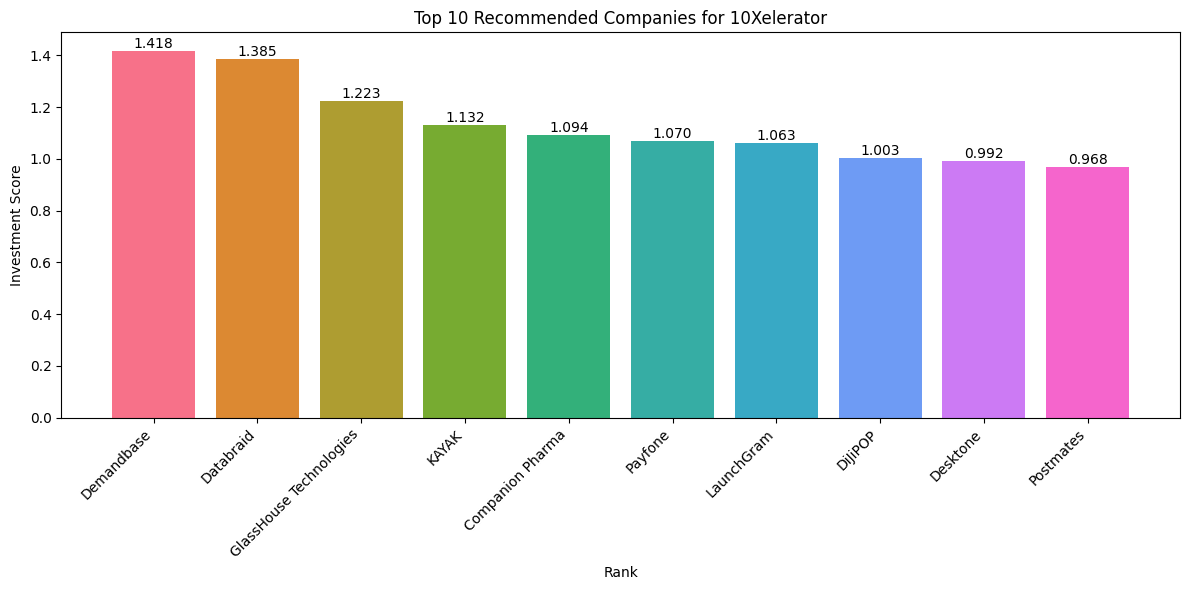


Input Shapes:
Investor input shape: (432, 1)
Company input shape: (432, 1)
Context input shape: (432, 10)

Value Ranges:
Company input range: [0, 431]
Context input sample: [4. 1. 9.] ...

Top 10 Recommended Companies:
1. Demandbase: 1.2088
2. Databraid: 1.1925
3. GlassHouse Technologies: 1.1116
4. KAYAK: 1.0660
5. Companion Pharma: 1.0468
6. Payfone: 1.0351
7. LaunchGram: 1.0314
8. DiJiPOP: 1.0013
9. Desktone: 0.9961
10. Postmates: 0.9841

=== Performance Evaluation for 10Xelerator ===
Number of actual investments: 65.0

Classification Metrics:
Accuracy: 0.7083
Precision: 0.0704
Recall: 0.0769
F1: 0.0735
Auc Roc: 0.4897

Ranking Metrics:
precision@5: 0.0000
recall@5: 0.0000
precision@10: 0.1000
recall@10: 0.0154
precision@20: 0.1000
recall@20: 0.0308

Score Distribution:
Positive Examples:
  Mean: 0.1412
  Std: 0.2439
Negative Examples:
  Mean: 0.1916
  Std: 0.3126


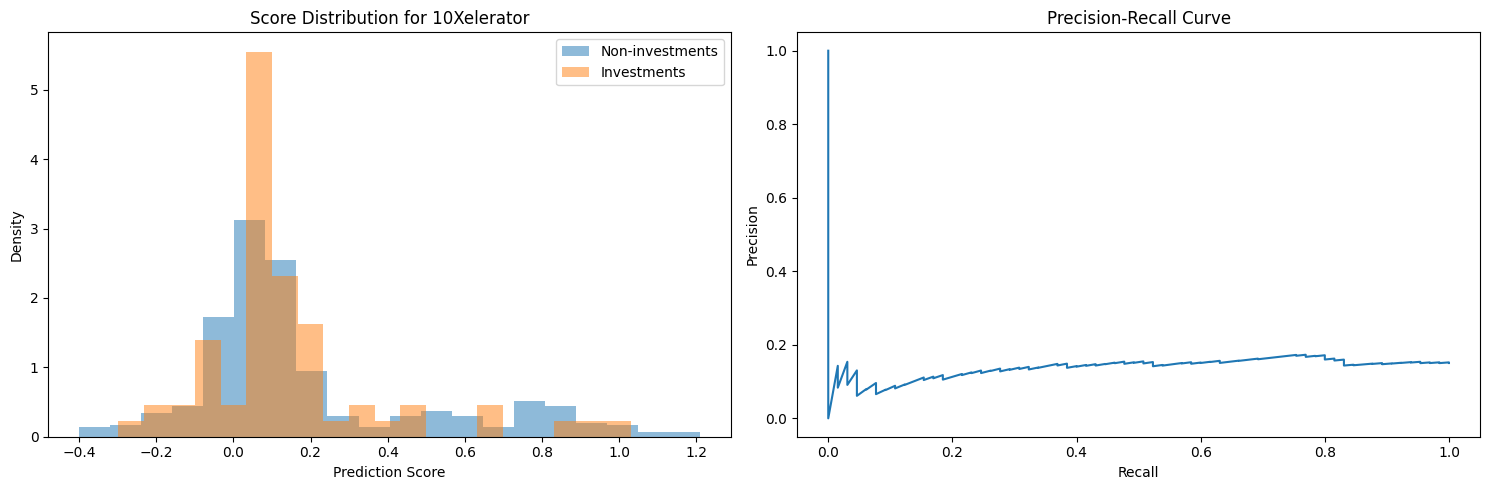

In [ ]:
def test_model_prediction(model, investor_name):
    try:
        investor_id = investor_encoder.transform([investor_name])[0]
        print(f"Investor ID: {investor_id}")

        # Reshape inputs
        investor_input = np.array([[investor_id]])  # Add extra dimension
        company_input = np.array([[0]])  # Add extra dimension
        context_input = context_features.iloc[[0]].values

        print("Updated Shapes:")
        print(f"Investor input: {investor_input.shape}")
        print(f"Company input: {company_input.shape}")
        print(f"Context input: {context_input.shape}")

        # Print model input shape expectations
        print("\nModel input shapes:")
        for layer in model.inputs:
            print(f"{layer.name}: {layer.shape}")

        # Test prediction
        test_pred = model.predict([investor_input, company_input, context_input], verbose=0)

        print(f"Test prediction successful, shape: {test_pred.shape}")
        print(f"Test prediction value: {test_pred}")

        return True
    except Exception as e:
        print(f"Error in test prediction: {e}")
        return False

def get_recommendations(model, investor_name):
    investor_id = investor_encoder.transform([investor_name])[0]
    all_scores = []

    # Process companies in batches
    batch_size = 100
    for i in range(0, num_companies, batch_size):
        # Create batch indices
        batch_indices = np.arange(i, min(i + batch_size, num_companies))
        batch_size_actual = len(batch_indices)

        # Prepare inputs with correct shapes
        investor_batch = np.full((batch_size_actual, 1), investor_id)
        company_batch = batch_indices.reshape(-1, 1)
        context_batch = context_features.iloc[batch_indices].values

        # Make prediction
        batch_scores = model.predict(
            [investor_batch, company_batch, context_batch],
            verbose=0
        )
        all_scores.extend(batch_scores.flatten())

    return np.array(all_scores)

def visualize_recommendations(model, investor_name, top_n=10):
    try:
        # Get scores for all companies
        scores = get_recommendations(model, investor_name)

        # Get top companies
        top_indices = np.argsort(scores)[::-1][:top_n]
        top_scores = scores[top_indices]
        top_companies = company_encoder.inverse_transform(top_indices)

        # Create visualization
        plt.figure(figsize=(12, 6))
        colors = sns.color_palette("husl", n_colors=top_n)

        # Bar plot
        bars = plt.bar(range(top_n), top_scores, color=colors)
        plt.xlabel('Rank')
        plt.ylabel('Investment Score')
        plt.title(f'Top {top_n} Recommended Companies for {investor_name}')

        # Rotate company names
        plt.xticks(range(top_n), top_companies, rotation=45, ha='right')

        # Add score labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        return top_companies, top_scores

    except Exception as e:
        print(f"Error in visualization: {e}")
        traceback.print_exc()
        return [], []

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
import traceback



def evaluate_investor_performance(model, investor_name, df, context_features):
    try:
        # Convert investor name to ID
        investor_id = investor_encoder.transform([investor_name])[0]

        # Use the number of companies from the encoder
        num_companies = len(company_encoder.classes_)  # This should be 432

        # Prepare prediction inputs
        investor_input = np.full((num_companies, 1), investor_id)
        company_input = np.arange(num_companies).reshape(-1, 1)

        # Since context_features has a RangeIndex, we just need to slice it
        context_input = context_features.iloc[:num_companies].values

        # Verify shapes and data before prediction
        print("\nInput Shapes:")
        print(f"Investor input shape: {investor_input.shape}")
        print(f"Company input shape: {company_input.shape}")
        print(f"Context input shape: {context_input.shape}")

        # Additional verification
        print("\nValue Ranges:")
        print(f"Company input range: [{np.min(company_input)}, {np.max(company_input)}]")
        print(f"Context input sample:", context_input[0][:3], "...")  # Show first 3 values of first row

        # Get model predictions
        predictions = model.predict(
            [investor_input, company_input, context_input],
            verbose=0,
            batch_size=32  # Added batch size for stability
        ).flatten()

        # Scale predictions if using tanh activation
        predictions = predictions * 0.5 + 0.5

        # Get actual investments for this investor
        investor_companies = df[df['investor_name'] == investor_name]['company_name'].unique()
        investor_company_ids = company_encoder.transform(investor_companies)

        # Create binary truth vector
        y_true = np.zeros(num_companies)
        y_true[investor_company_ids] = 1

        # Calculate metrics
        y_pred = (predictions > 0.5).astype(int)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_true, predictions)
        }

        # Calculate top-k metrics
        top_k = [5, 10, 20]
        top_k_metrics = {}

        for k in top_k:
            top_indices = np.argsort(predictions)[::-1][:k]
            true_positives = np.sum(y_true[top_indices])

            precision_k = true_positives / k
            recall_k = true_positives / np.sum(y_true) if np.sum(y_true) > 0 else 0

            top_k_metrics[f'precision@{k}'] = precision_k
            top_k_metrics[f'recall@{k}'] = recall_k

            # Print top k recommendations
            if k == 10:  # Show top 10 recommendations
                print(f"\nTop {k} Recommended Companies:")
                top_companies = company_encoder.inverse_transform(top_indices)
                for i, (company, score) in enumerate(zip(top_companies, predictions[top_indices]), 1):
                    print(f"{i}. {company}: {score:.4f}")

        # Print results
        print(f"\n=== Performance Evaluation for {investor_name} ===")
        print(f"Number of actual investments: {np.sum(y_true)}")

        print("\nClassification Metrics:")
        for metric, value in metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

        print("\nRanking Metrics:")
        for metric, value in top_k_metrics.items():
            print(f"{metric}: {value:.4f}")

        # Score distribution analysis
        positive_scores = predictions[y_true == 1]
        negative_scores = predictions[y_true == 0]

        print("\nScore Distribution:")
        if len(positive_scores) > 0:
            print("Positive Examples:")
            print(f"  Mean: {np.mean(positive_scores):.4f}")
            print(f"  Std: {np.std(positive_scores):.4f}")
        print("Negative Examples:")
        print(f"  Mean: {np.mean(negative_scores):.4f}")
        print(f"  Std: {np.std(negative_scores):.4f}")

        # Visualization
        plt.figure(figsize=(15, 5))

        # Score distribution
        plt.subplot(1, 2, 1)
        plt.hist(negative_scores, bins=20, alpha=0.5, label='Non-investments', density=True)
        if len(positive_scores) > 0:
            plt.hist(positive_scores, bins=20, alpha=0.5, label='Investments', density=True)
        plt.title(f'Score Distribution for {investor_name}')
        plt.xlabel('Prediction Score')
        plt.ylabel('Density')
        plt.legend()

        # Precision-Recall curve
        plt.subplot(1, 2, 2)
        precisions, recalls, _ = precision_recall_curve(y_true, predictions)
        plt.plot(recalls, precisions)
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        plt.tight_layout()
        plt.show()

        return {
            'basic_metrics': metrics,
            'ranking_metrics': top_k_metrics,
            'predictions': predictions,
            'y_true': y_true,
            'score_distribution': {
                'positive': positive_scores,
                'negative': negative_scores
            }
        }

    except Exception as e:
        print(f"Error in investor evaluation: {e}")
        print("\nDebug Information:")
        print(f"Number of companies in context_features: {len(context_features)}")
        print(f"Number of companies in company_encoder: {len(company_encoder.classes_)}")
        print(f"Context features shape: {context_features.shape}")
        traceback.print_exc()
        return None

# First let's run the test to see the model's input requirements
investor_name = investor_encoder.classes_[0]
success = test_model_prediction(model, investor_name)

if success:
    print("\nProceeding with visualization...")
    # Run visualization
    visualize_recommendations(model, investor_name)

    # And evaluation
    evaluate_investor_performance(model, investor_name, df, context_features)

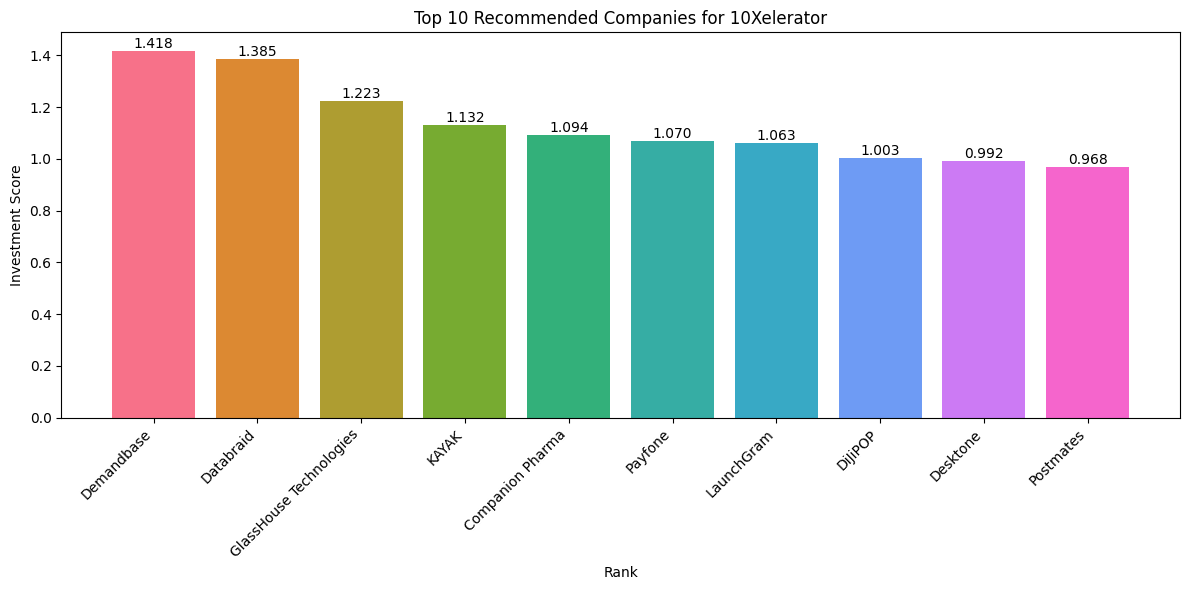


Top 10 Recommended Companies for 10Xelerator:
1. Demandbase: 1.4176
2. Databraid: 1.3849
3. GlassHouse Technologies: 1.2233
4. KAYAK: 1.1320
5. Companion Pharma: 1.0936
6. Payfone: 1.0702
7. LaunchGram: 1.0628
8. DiJiPOP: 1.0027
9. Desktone: 0.9922
10. Postmates: 0.9683


(array(['Demandbase', 'Databraid', 'GlassHouse Technologies', 'KAYAK',
        'Companion Pharma', 'Payfone', 'LaunchGram', 'DiJiPOP', 'Desktone',
        'Postmates'], dtype=object),
 array([1.4176311, 1.3849133, 1.223255 , 1.1319858, 1.0936053, 1.0702125,
        1.0627629, 1.00268  , 0.9921579, 0.9682761], dtype=float32))

In [ ]:
def get_recommendations(model, investor_name):
    investor_id = investor_encoder.transform([investor_name])[0]
    all_scores = []

    # Process companies in batches
    batch_size = 100
    for i in range(0, num_companies, batch_size):
        # Create batch indices
        batch_indices = np.arange(i, min(i + batch_size, num_companies))
        batch_size_actual = len(batch_indices)

        # Prepare inputs with verified shapes
        investor_batch = np.full((batch_size_actual, 1), investor_id)
        company_batch = batch_indices.reshape(-1, 1)
        context_batch = context_features.iloc[batch_indices].values

        # Make prediction
        batch_scores = model.predict(
            [investor_batch, company_batch, context_batch],
            verbose=0
        )
        all_scores.extend(batch_scores.flatten())

    return np.array(all_scores)

def visualize_recommendations(model, investor_name, top_n=10):
    try:
        # Get scores for all companies
        scores = get_recommendations(model, investor_name)

        # Get top companies
        top_indices = np.argsort(scores)[::-1][:top_n]
        top_scores = scores[top_indices]
        top_companies = company_encoder.inverse_transform(top_indices)

        # Create visualization
        plt.figure(figsize=(12, 6))
        colors = sns.color_palette("husl", n_colors=top_n)

        # Bar plot
        bars = plt.bar(range(top_n), top_scores, color=colors)
        plt.xlabel('Rank')
        plt.ylabel('Investment Score')
        plt.title(f'Top {top_n} Recommended Companies for {investor_name}')

        # Rotate company names
        plt.xticks(range(top_n), top_companies, rotation=45, ha='right')

        # Add score labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Print recommendations in text format too
        print(f"\nTop {top_n} Recommended Companies for {investor_name}:")
        for i, (company, score) in enumerate(zip(top_companies, top_scores), 1):
            print(f"{i}. {company}: {score:.4f}")

        return top_companies, top_scores

    except Exception as e:
        print(f"Error in visualization: {e}")
        return [], []

# Run visualization for the first investor
investor_name = investor_encoder.classes_[0]  # '10Xelerator'
visualize_recommendations(model, investor_name)

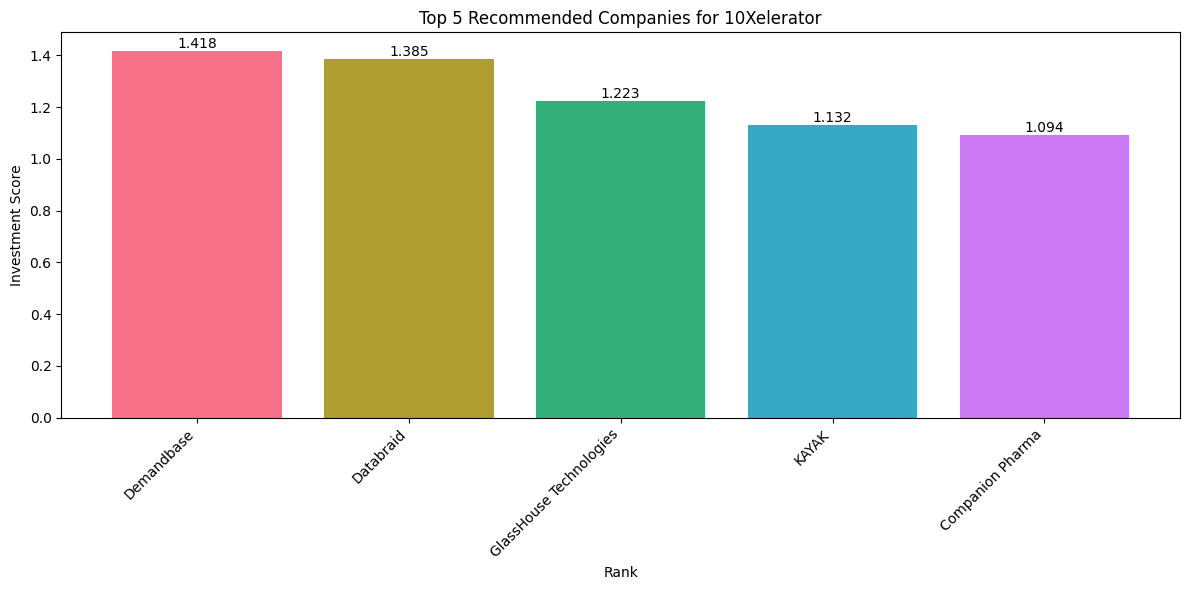


Top 5 Recommended Companies for 10Xelerator:
1. Demandbase: 1.4176
2. Databraid: 1.3849
3. GlassHouse Technologies: 1.2233
4. KAYAK: 1.1320
5. Companion Pharma: 1.0936

=== Recommendation Comparison ===

Target Investor: 10Xelerator
Top Recommendations:
  Demandbase: 1.4176
  Databraid: 1.3849
  GlassHouse Technologies: 1.2233
  KAYAK: 1.1320
  Companion Pharma: 1.0936

Similar Investors and Their Recommendations:

Bertelsmann (Similarity: 0.7609)


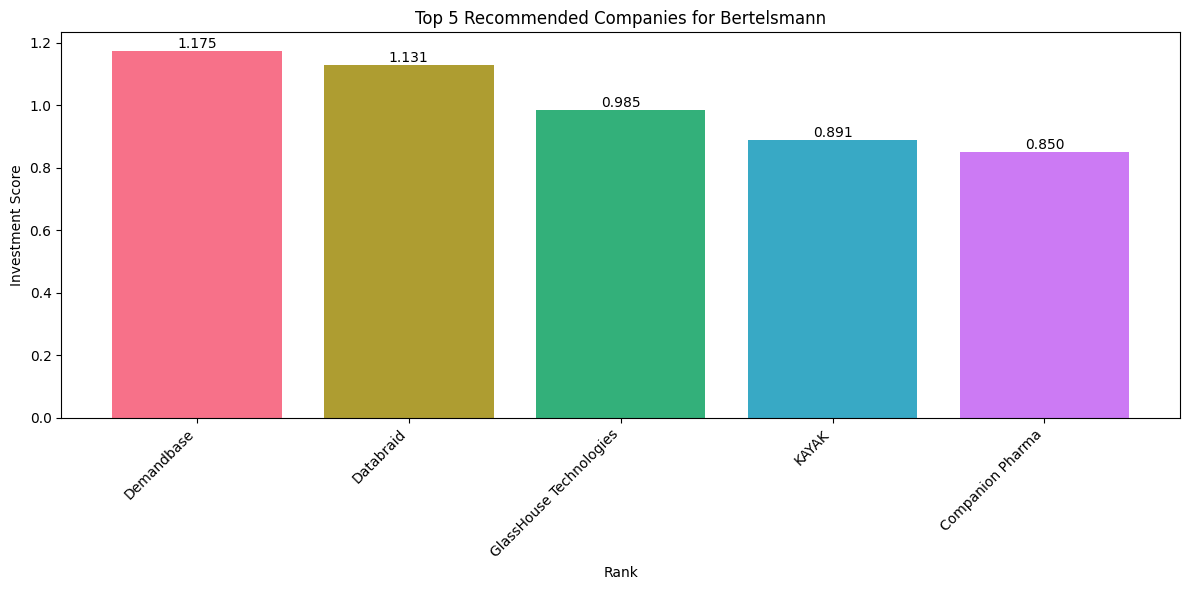


Top 5 Recommended Companies for Bertelsmann:
1. Demandbase: 1.1751
2. Databraid: 1.1307
3. GlassHouse Technologies: 0.9850
4. KAYAK: 0.8905
5. Companion Pharma: 0.8497
Common recommendations:
  Databraid
  KAYAK
  Demandbase
  Companion Pharma
  GlassHouse Technologies

Awesome Inc (Similarity: 0.7421)


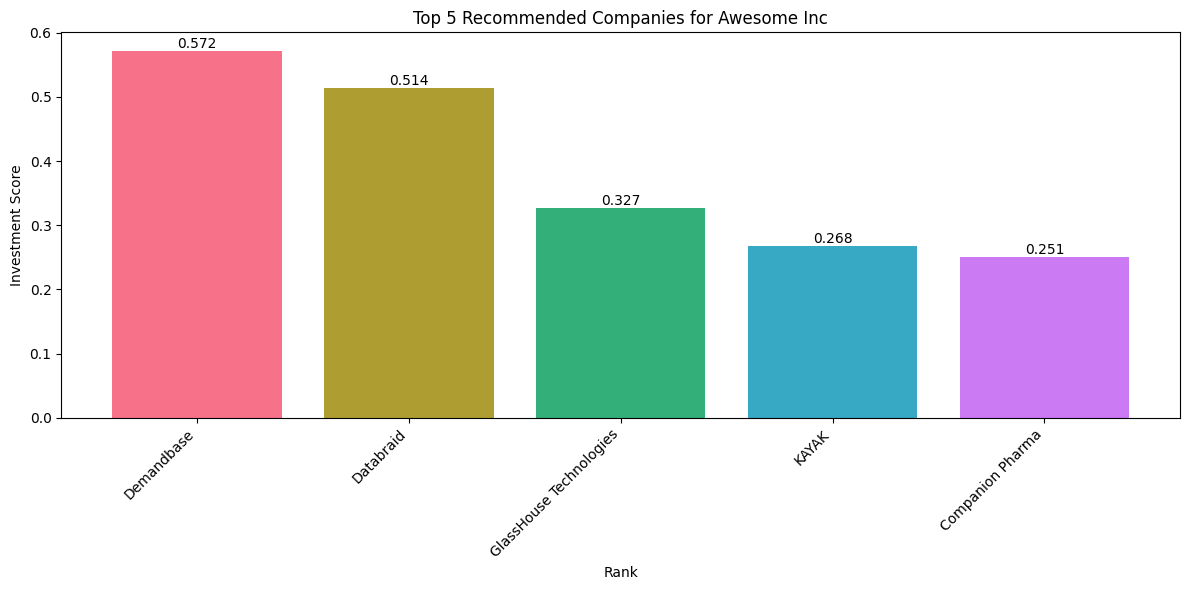


Top 5 Recommended Companies for Awesome Inc:
1. Demandbase: 0.5720
2. Databraid: 0.5135
3. GlassHouse Technologies: 0.3275
4. KAYAK: 0.2683
5. Companion Pharma: 0.2511
Common recommendations:
  Databraid
  KAYAK
  Demandbase
  Companion Pharma
  GlassHouse Technologies

Celgene (Similarity: 0.7406)


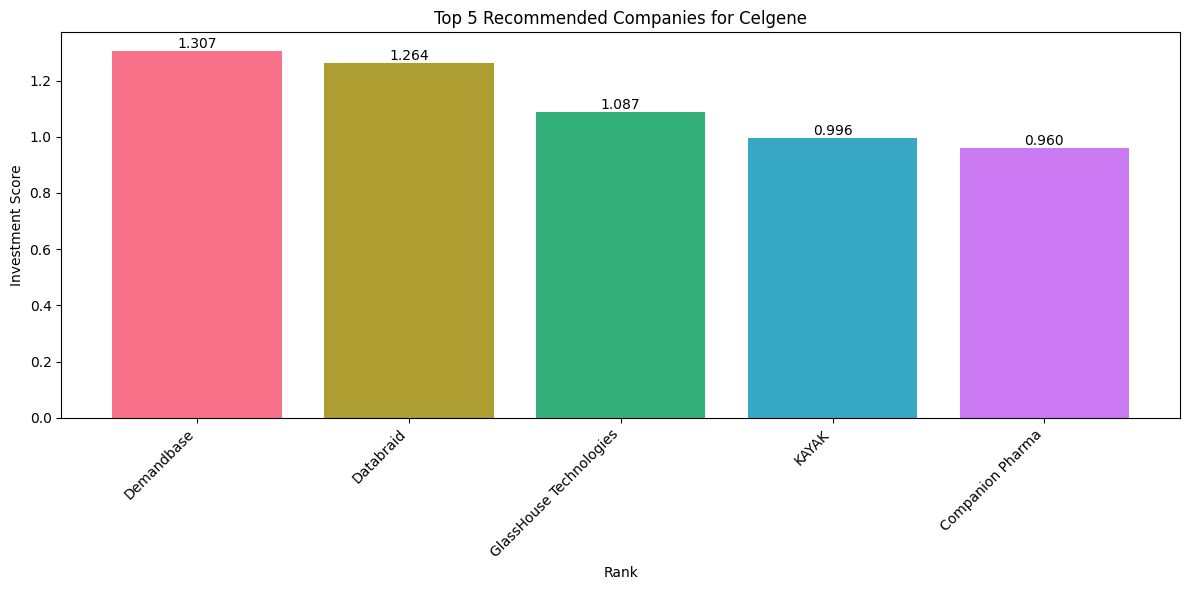


Top 5 Recommended Companies for Celgene:
1. Demandbase: 1.3065
2. Databraid: 1.2638
3. GlassHouse Technologies: 1.0871
4. KAYAK: 0.9964
5. Companion Pharma: 0.9599
Common recommendations:
  Databraid
  KAYAK
  Demandbase
  Companion Pharma
  GlassHouse Technologies

ConocoPhillips (Similarity: 0.6873)


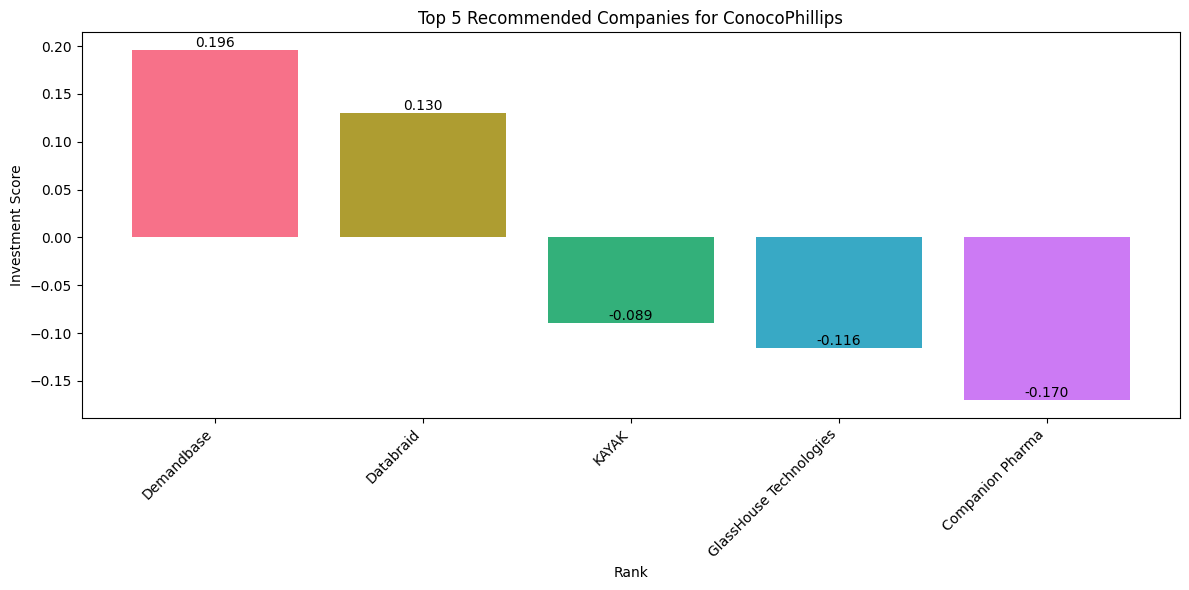


Top 5 Recommended Companies for ConocoPhillips:
1. Demandbase: 0.1960
2. Databraid: 0.1304
3. KAYAK: -0.0892
4. GlassHouse Technologies: -0.1161
5. Companion Pharma: -0.1701
Common recommendations:
  Databraid
  KAYAK
  Demandbase
  Companion Pharma
  GlassHouse Technologies

Boston Scientific (Similarity: 0.6796)


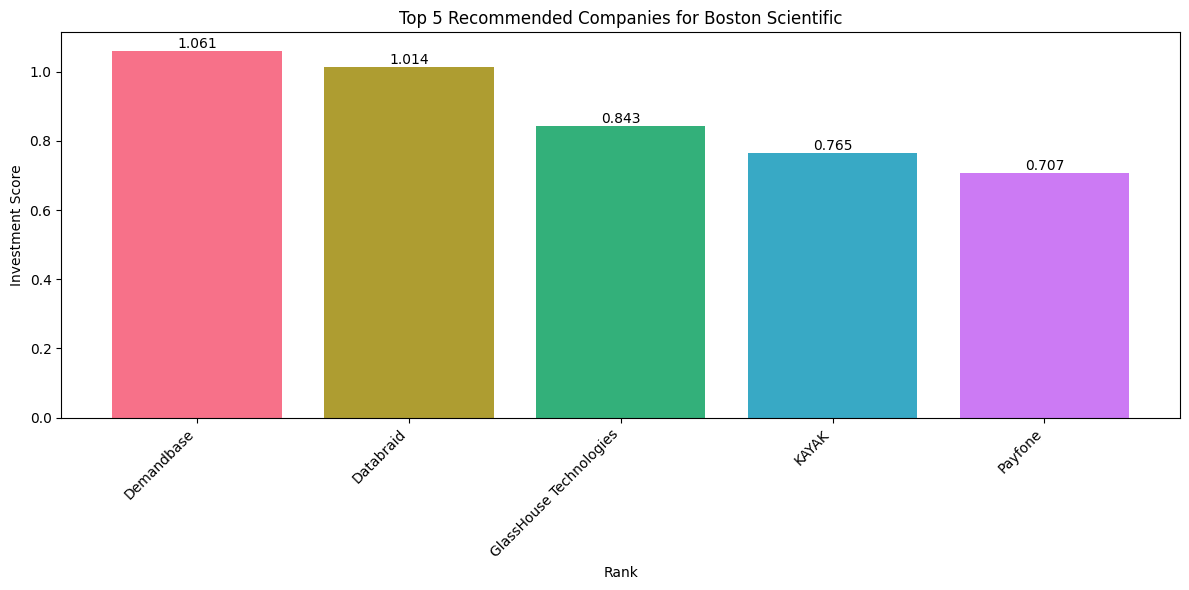


Top 5 Recommended Companies for Boston Scientific:
1. Demandbase: 1.0606
2. Databraid: 1.0138
3. GlassHouse Technologies: 0.8428
4. KAYAK: 0.7653
5. Payfone: 0.7075
Common recommendations:
  GlassHouse Technologies
  KAYAK
  Databraid
  Demandbase


<Figure size 1200x600 with 0 Axes>

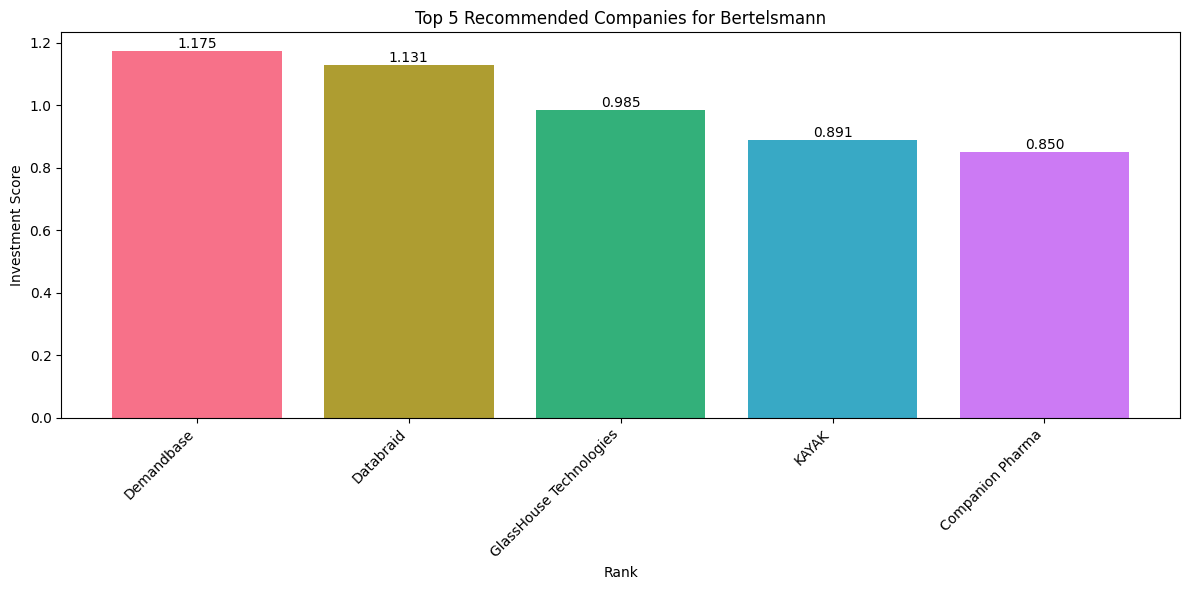


Top 5 Recommended Companies for Bertelsmann:
1. Demandbase: 1.1751
2. Databraid: 1.1307
3. GlassHouse Technologies: 0.9850
4. KAYAK: 0.8905
5. Companion Pharma: 0.8497


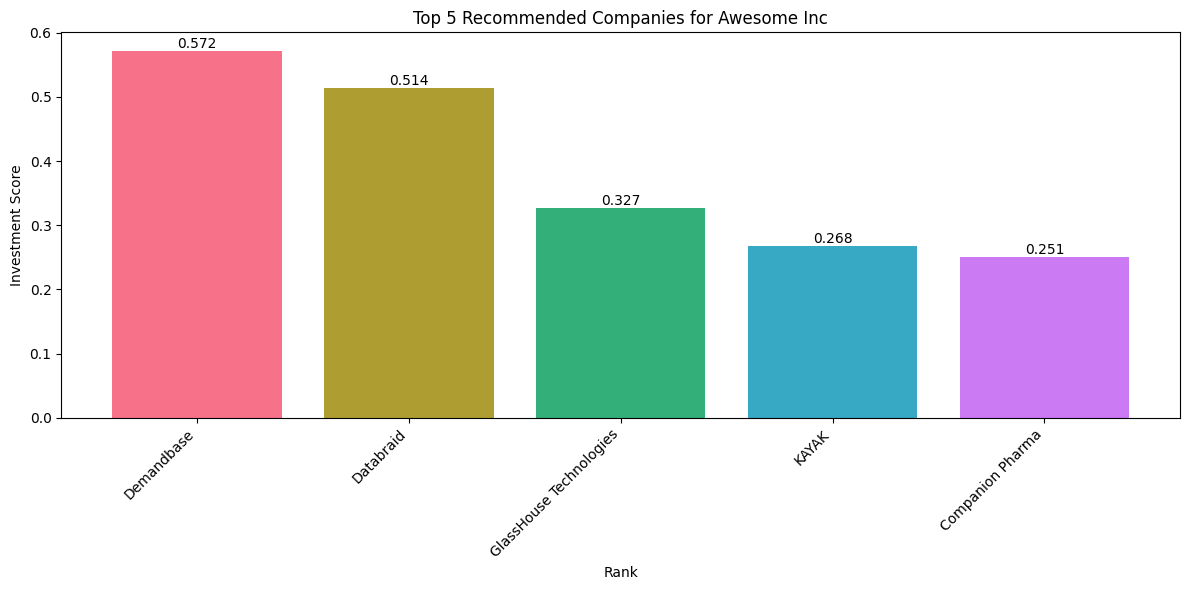


Top 5 Recommended Companies for Awesome Inc:
1. Demandbase: 0.5720
2. Databraid: 0.5135
3. GlassHouse Technologies: 0.3275
4. KAYAK: 0.2683
5. Companion Pharma: 0.2511


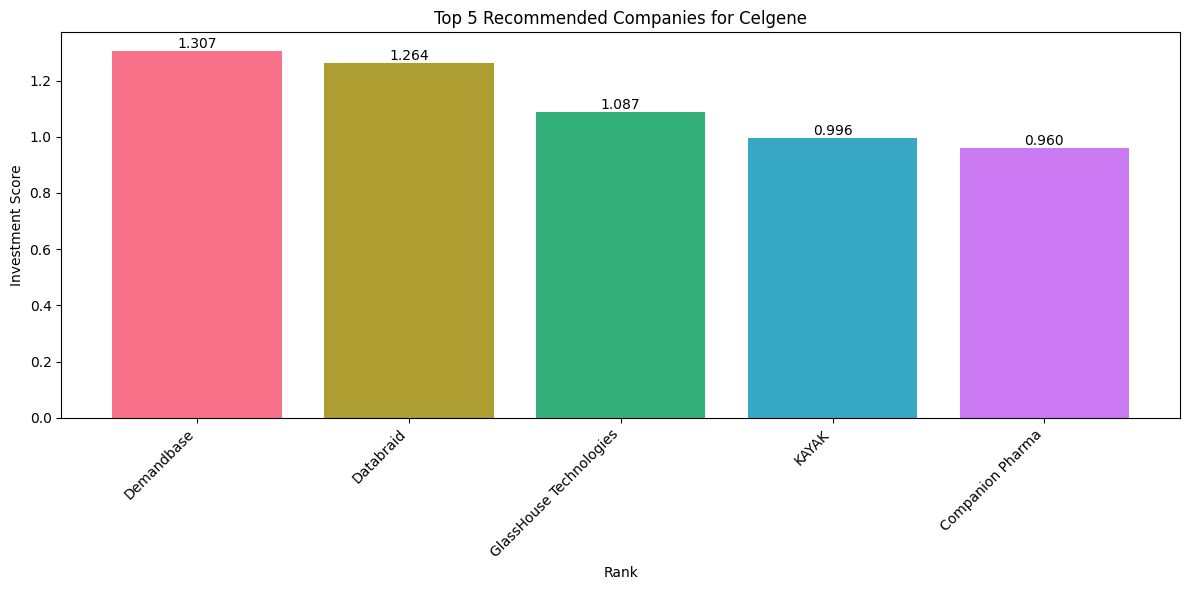


Top 5 Recommended Companies for Celgene:
1. Demandbase: 1.3065
2. Databraid: 1.2638
3. GlassHouse Technologies: 1.0871
4. KAYAK: 0.9964
5. Companion Pharma: 0.9599


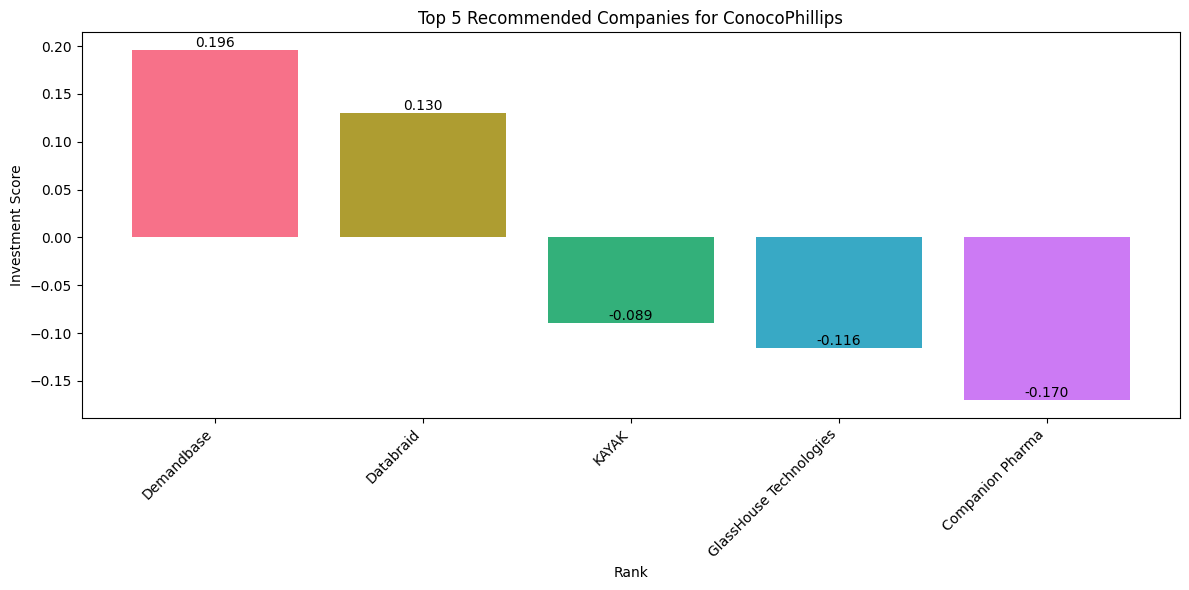


Top 5 Recommended Companies for ConocoPhillips:
1. Demandbase: 0.1960
2. Databraid: 0.1304
3. KAYAK: -0.0892
4. GlassHouse Technologies: -0.1161
5. Companion Pharma: -0.1701


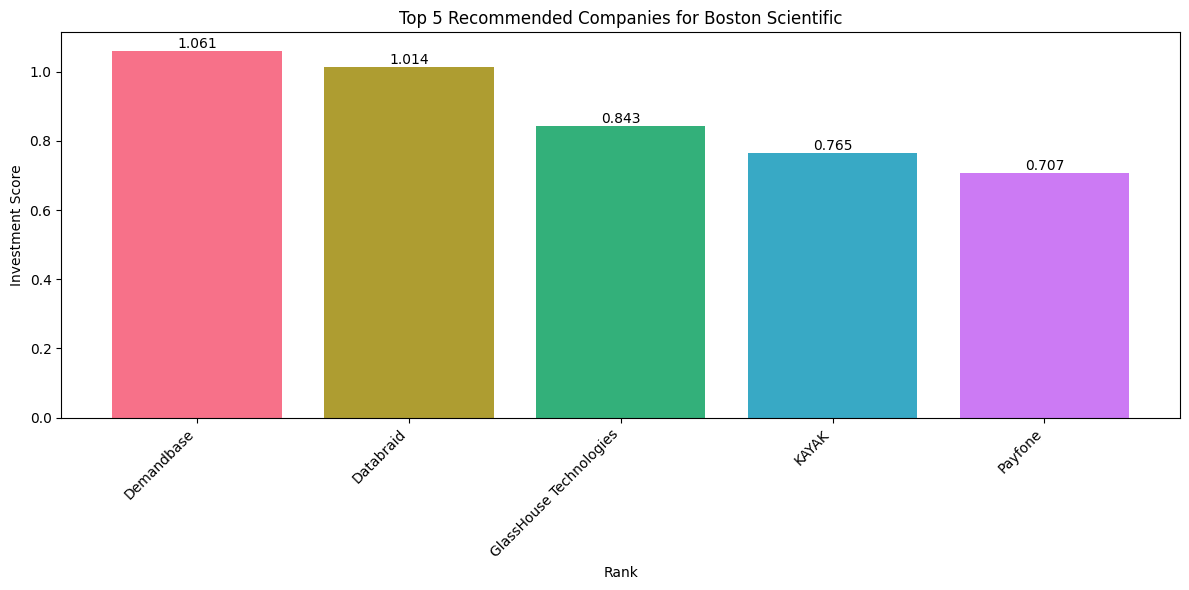


Top 5 Recommended Companies for Boston Scientific:
1. Demandbase: 1.0606
2. Databraid: 1.0138
3. GlassHouse Technologies: 0.8428
4. KAYAK: 0.7653
5. Payfone: 0.7075


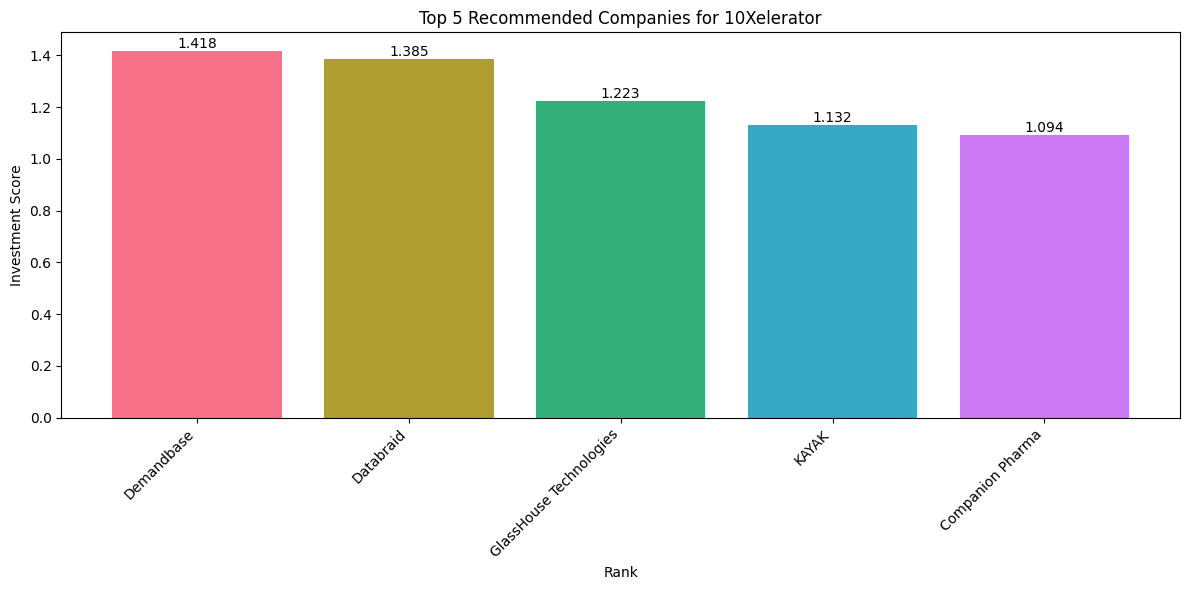


Top 5 Recommended Companies for 10Xelerator:
1. Demandbase: 1.4176
2. Databraid: 1.3849
3. GlassHouse Technologies: 1.2233
4. KAYAK: 1.1320
5. Companion Pharma: 1.0936


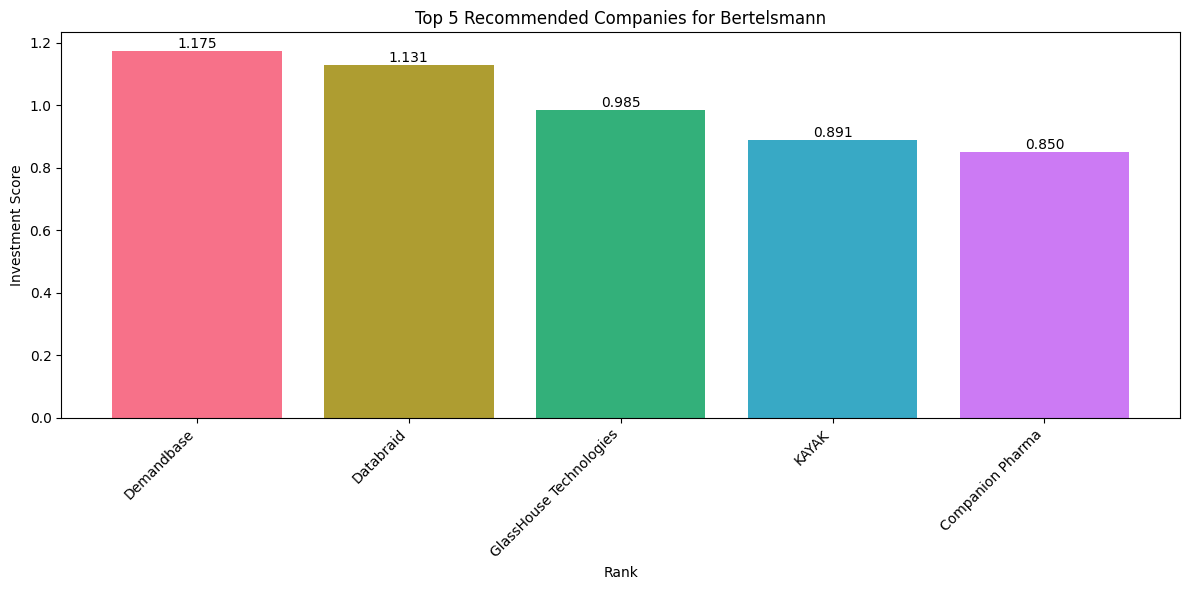


Top 5 Recommended Companies for Bertelsmann:
1. Demandbase: 1.1751
2. Databraid: 1.1307
3. GlassHouse Technologies: 0.9850
4. KAYAK: 0.8905
5. Companion Pharma: 0.8497


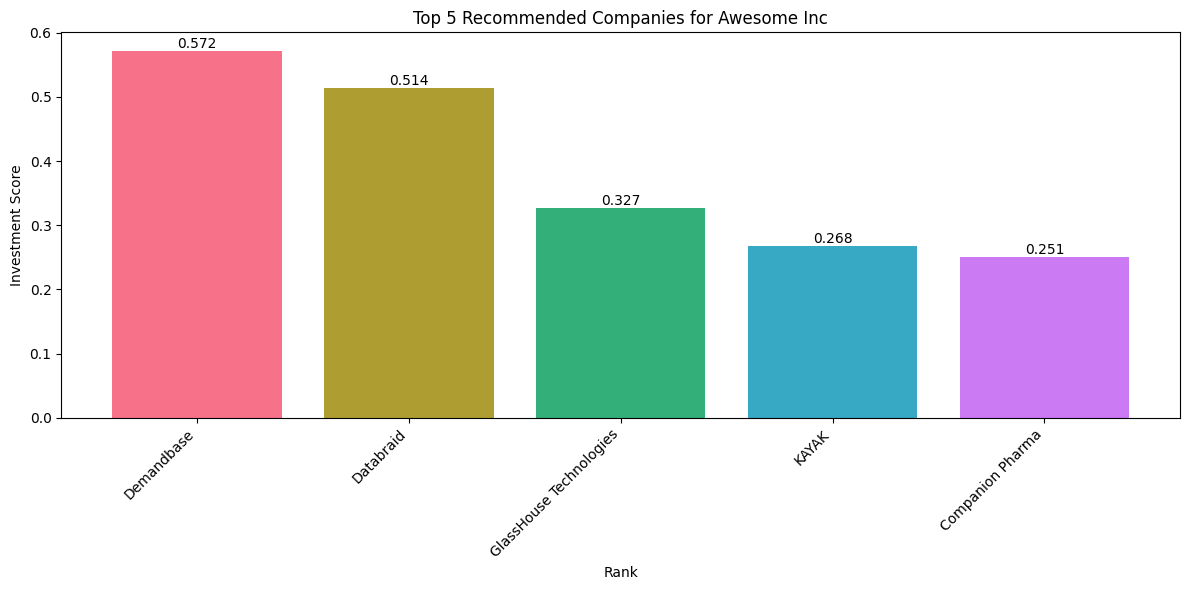


Top 5 Recommended Companies for Awesome Inc:
1. Demandbase: 0.5720
2. Databraid: 0.5135
3. GlassHouse Technologies: 0.3275
4. KAYAK: 0.2683
5. Companion Pharma: 0.2511


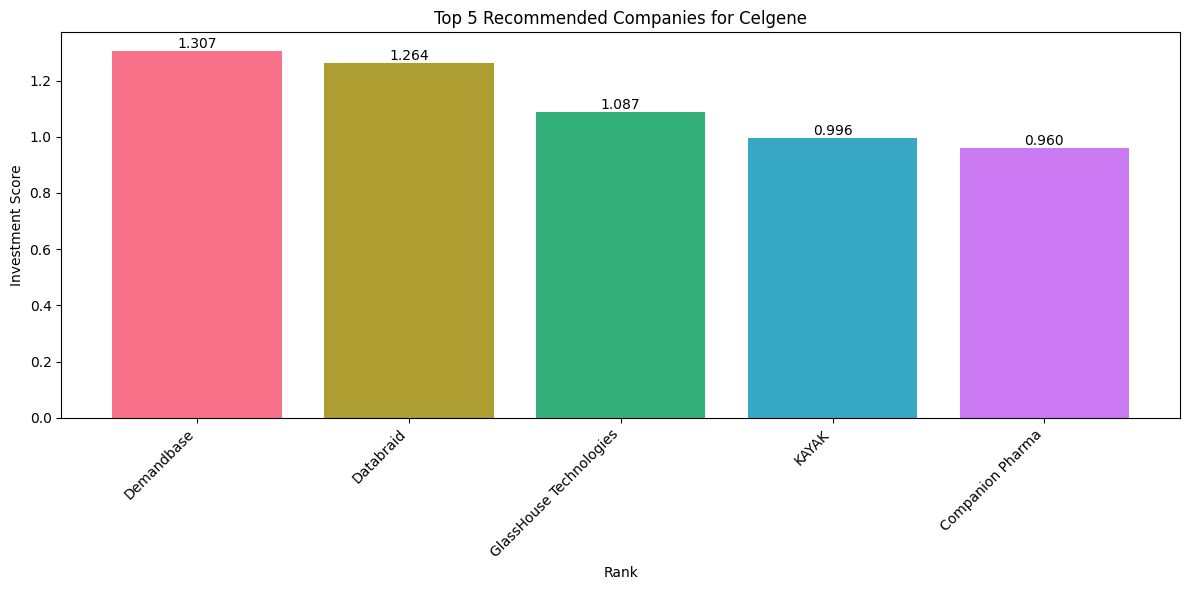


Top 5 Recommended Companies for Celgene:
1. Demandbase: 1.3065
2. Databraid: 1.2638
3. GlassHouse Technologies: 1.0871
4. KAYAK: 0.9964
5. Companion Pharma: 0.9599


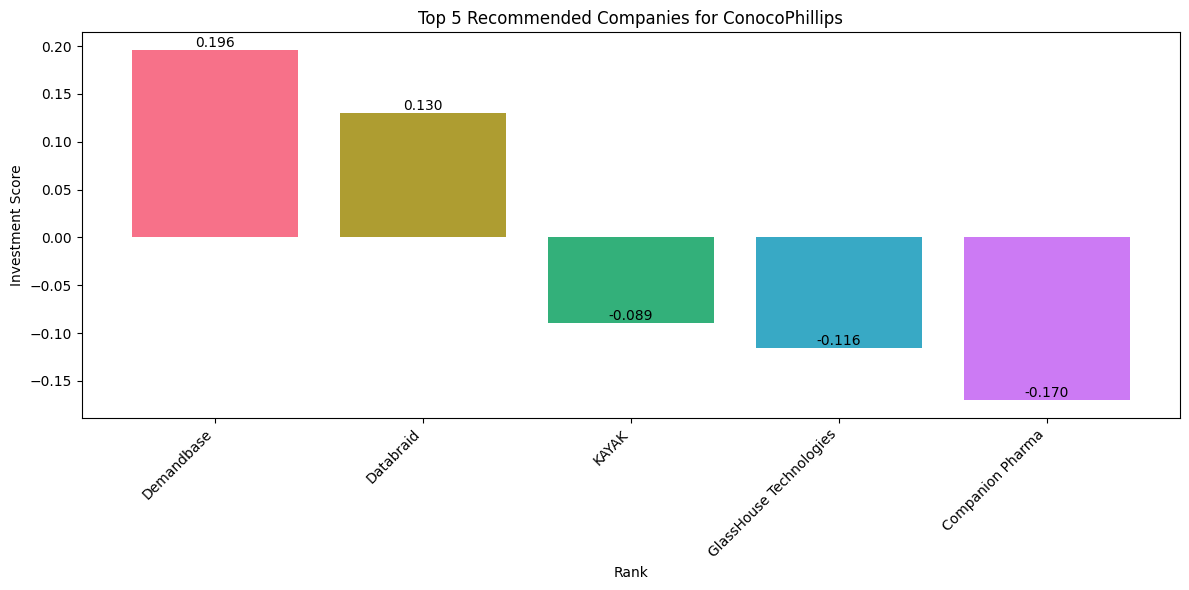


Top 5 Recommended Companies for ConocoPhillips:
1. Demandbase: 0.1960
2. Databraid: 0.1304
3. KAYAK: -0.0892
4. GlassHouse Technologies: -0.1161
5. Companion Pharma: -0.1701


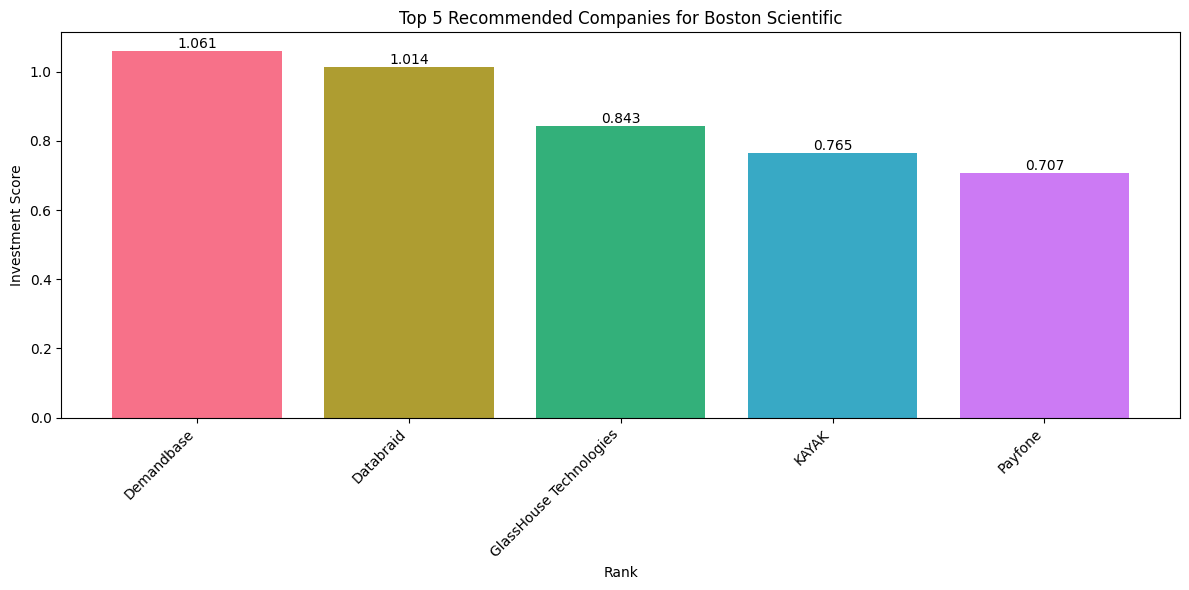


Top 5 Recommended Companies for Boston Scientific:
1. Demandbase: 1.0606
2. Databraid: 1.0138
3. GlassHouse Technologies: 0.8428
4. KAYAK: 0.7653
5. Payfone: 0.7075


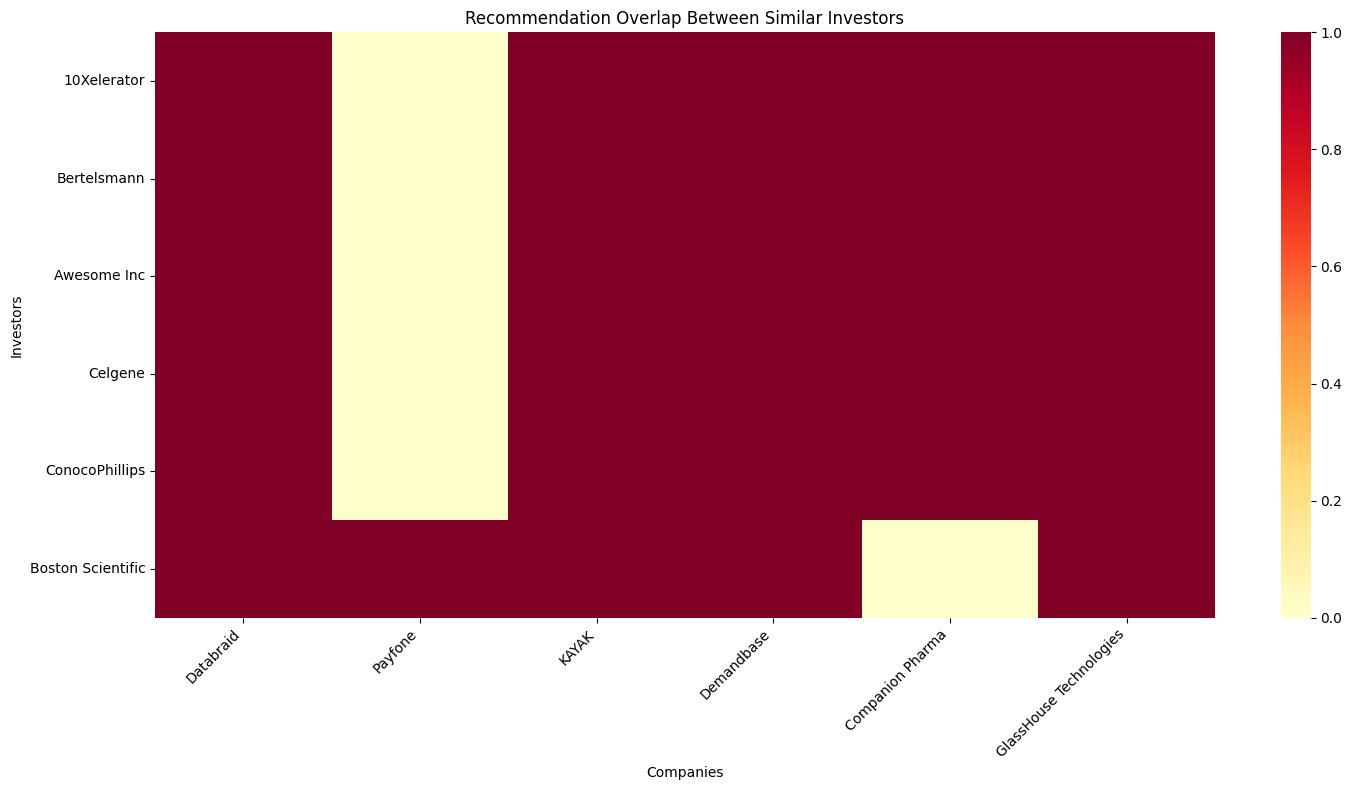

(array(['Demandbase', 'Databraid', 'GlassHouse Technologies', 'KAYAK',
        'Companion Pharma'], dtype=object),
 [('Bertelsmann', 0.7609127),
  ('Awesome Inc', 0.7420965),
  ('Celgene', 0.7405655),
  ('ConocoPhillips', 0.6872626),
  ('Boston Scientific', 0.67961425)])

In [ ]:
def find_similar_investors(model, target_investor_name, num_similar=5):
   """
   Find similar investors based on their embedding patterns
   """
   try:
       # Get investor embeddings from the model
       investor_embedding_layer = model.get_layer('Investor_Embedding')
       all_investor_embeddings = investor_embedding_layer.get_weights()[0]

       # Get target investor embedding
       target_id = investor_encoder.transform([target_investor_name])[0]
       target_embedding = all_investor_embeddings[target_id]

       # Calculate cosine similarity with all investors
       similarities = []
       for i, embedding in enumerate(all_investor_embeddings):
           if i != target_id:  # Skip the target investor
               similarity = np.dot(target_embedding, embedding) / (
                   np.linalg.norm(target_embedding) * np.linalg.norm(embedding)
               )
               similarities.append((i, similarity))

       # Sort by similarity and get top similar investors
       similar_investors = sorted(similarities, key=lambda x: x[1], reverse=True)[:num_similar]

       return [(investor_encoder.inverse_transform([idx])[0], sim) for idx, sim in similar_investors]

   except Exception as e:
       print(f"Error finding similar investors: {e}")
       return []

def compare_recommendations(model, target_investor, similar_investors, top_n=5):
   """
   Compare recommendations between target investor and similar investors
   """
   try:
       # Get recommendations for target investor
       target_recs, target_scores = visualize_recommendations(model, target_investor, top_n)

       print(f"\n=== Recommendation Comparison ===")
       print(f"\nTarget Investor: {target_investor}")
       print("Top Recommendations:")
       for company, score in zip(target_recs, target_scores):
           print(f"  {company}: {score:.4f}")

       # Get recommendations for similar investors
       print("\nSimilar Investors and Their Recommendations:")
       for investor, similarity in similar_investors:
           print(f"\n{investor} (Similarity: {similarity:.4f})")
           recs, scores = visualize_recommendations(model, investor, top_n)

           # Find common recommendations
           common_recs = set(target_recs).intersection(set(recs))
           if common_recs:
               print("Common recommendations:")
               for company in common_recs:
                   print(f"  {company}")
           else:
               print("No common recommendations")

       # Visualize recommendation overlap
       plt.figure(figsize=(12, 6))

       # Create a set of all unique companies
       all_companies = set(target_recs)
       for investor, _ in similar_investors:
           recs, _ = visualize_recommendations(model, investor, top_n)
           all_companies.update(recs)

       # Create matrix of recommendations
       investors = [target_investor] + [inv for inv, _ in similar_investors]
       recommendation_matrix = np.zeros((len(investors), len(all_companies)))

       for i, investor in enumerate(investors):
           recs, _ = visualize_recommendations(model, investor, top_n)
           for j, company in enumerate(all_companies):
               if company in recs:
                   recommendation_matrix[i, j] = 1

       # Plot heatmap
       plt.figure(figsize=(15, 8))
       sns.heatmap(recommendation_matrix,
                  xticklabels=list(all_companies),
                  yticklabels=investors,
                  cmap='YlOrRd')
       plt.title('Recommendation Overlap Between Similar Investors')
       plt.xlabel('Companies')
       plt.ylabel('Investors')
       plt.xticks(rotation=45, ha='right')
       plt.tight_layout()
       plt.show()

       return target_recs, similar_investors

   except Exception as e:
       print(f"Error comparing recommendations: {e}")
       return None, None

# Example usage
investor_name = investor_encoder.classes_[0]  # Use first investor as example
similar_investors = find_similar_investors(model, investor_name)
compare_recommendations(model, investor_name, similar_investors)

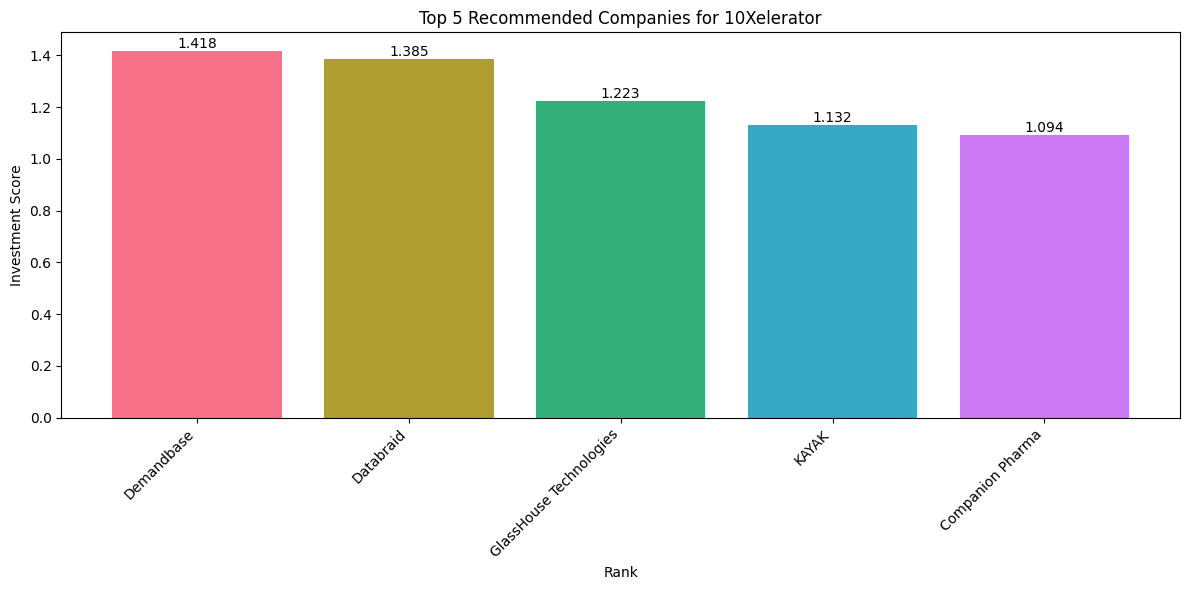


Top 5 Recommended Companies for 10Xelerator:
1. Demandbase: 1.4176
2. Databraid: 1.3849
3. GlassHouse Technologies: 1.2233
4. KAYAK: 1.1320
5. Companion Pharma: 1.0936

=== Recommendation Comparison (Dissimilar Investors) ===

Target Investor: 10Xelerator
Top Recommendations:
  Demandbase: 1.4176
  Databraid: 1.3849
  GlassHouse Technologies: 1.2233
  KAYAK: 1.1320
  Companion Pharma: 1.0936

Dissimilar Investors and Their Recommendations:

Cisco (Dissimilarity: 1.7605)


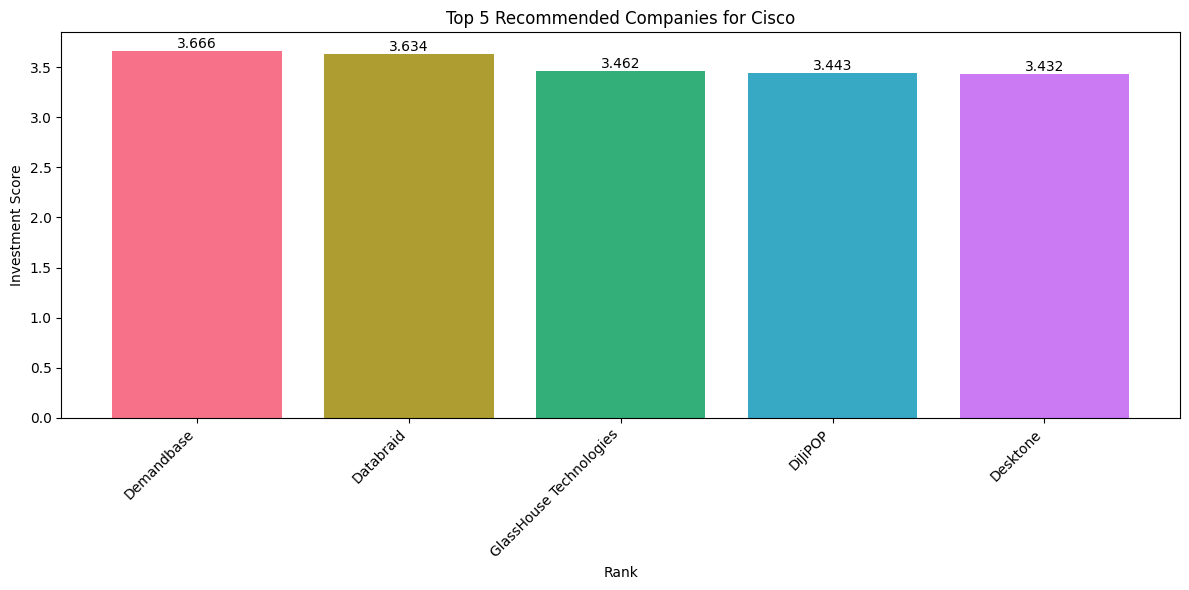


Top 5 Recommended Companies for Cisco:
1. Demandbase: 3.6660
2. Databraid: 3.6335
3. GlassHouse Technologies: 3.4617
4. DiJiPOP: 3.4433
5. Desktone: 3.4324
Unique recommendations:
  DiJiPOP
  Desktone

betaworks (Dissimilarity: 1.7497)


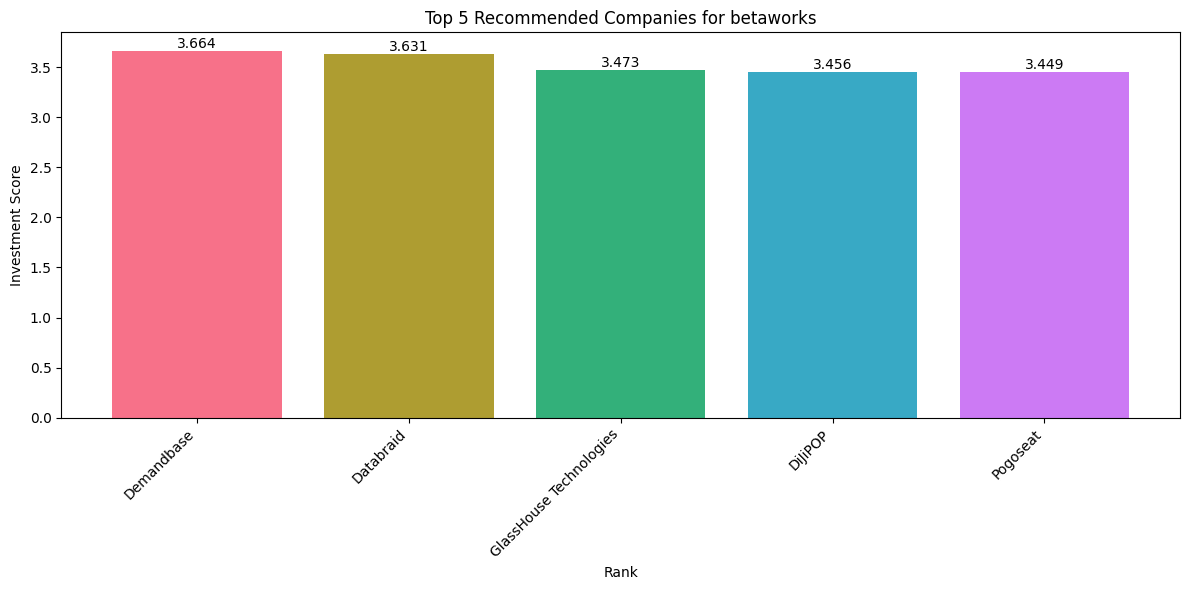


Top 5 Recommended Companies for betaworks:
1. Demandbase: 3.6641
2. Databraid: 3.6310
3. GlassHouse Technologies: 3.4728
4. DiJiPOP: 3.4559
5. Pogoseat: 3.4490
Unique recommendations:
  DiJiPOP
  Pogoseat

Betaspring (Dissimilarity: 1.6739)


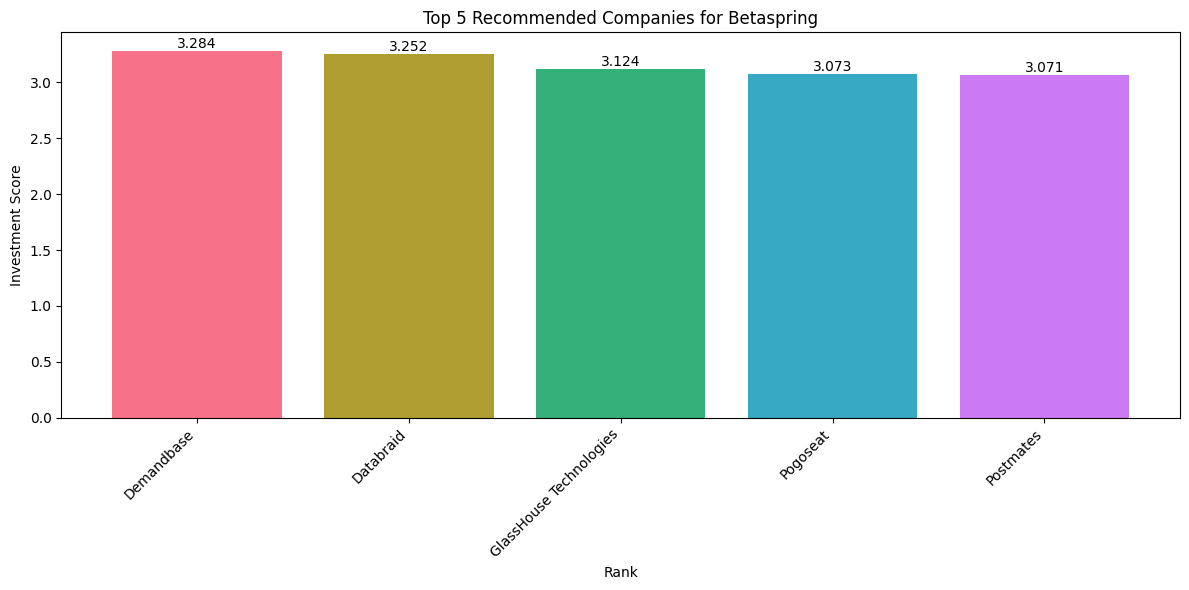


Top 5 Recommended Companies for Betaspring:
1. Demandbase: 3.2844
2. Databraid: 3.2525
3. GlassHouse Technologies: 3.1238
4. Pogoseat: 3.0734
5. Postmates: 3.0712
Unique recommendations:
  Postmates
  Pogoseat

Amazon (Dissimilarity: 1.6428)


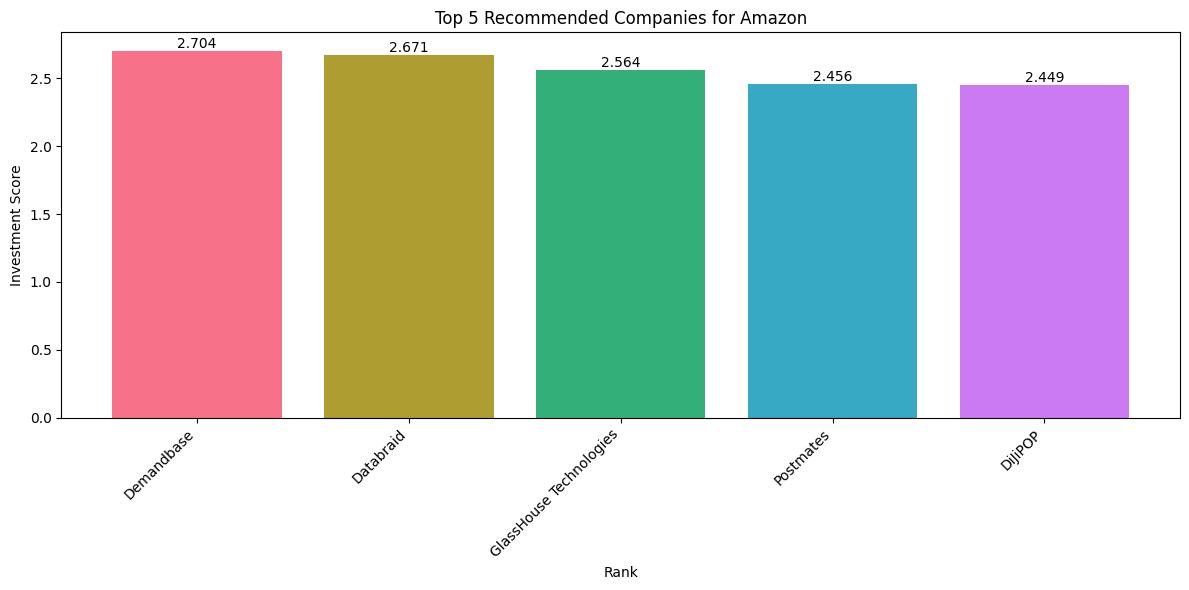


Top 5 Recommended Companies for Amazon:
1. Demandbase: 2.7036
2. Databraid: 2.6713
3. GlassHouse Technologies: 2.5639
4. Postmates: 2.4559
5. DiJiPOP: 2.4488
Unique recommendations:
  DiJiPOP
  Postmates

Entrepreneurs Roundtable Accelerator (Dissimilarity: 1.5010)


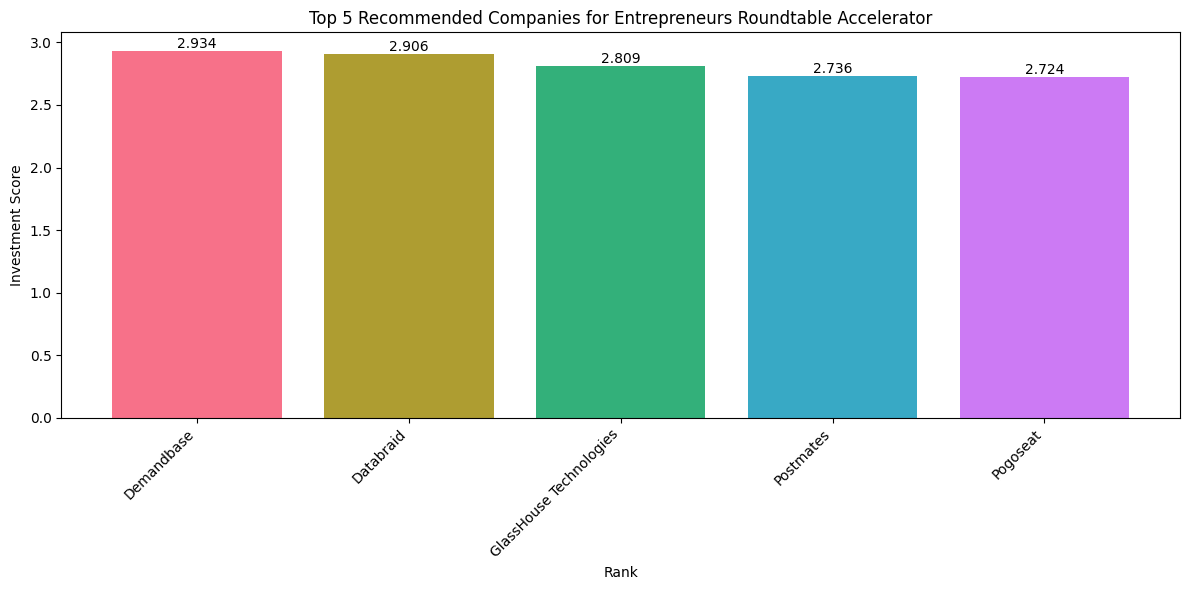


Top 5 Recommended Companies for Entrepreneurs Roundtable Accelerator:
1. Demandbase: 2.9340
2. Databraid: 2.9059
3. GlassHouse Technologies: 2.8087
4. Postmates: 2.7356
5. Pogoseat: 2.7243
Unique recommendations:
  Pogoseat
  Postmates


<Figure size 1200x600 with 0 Axes>

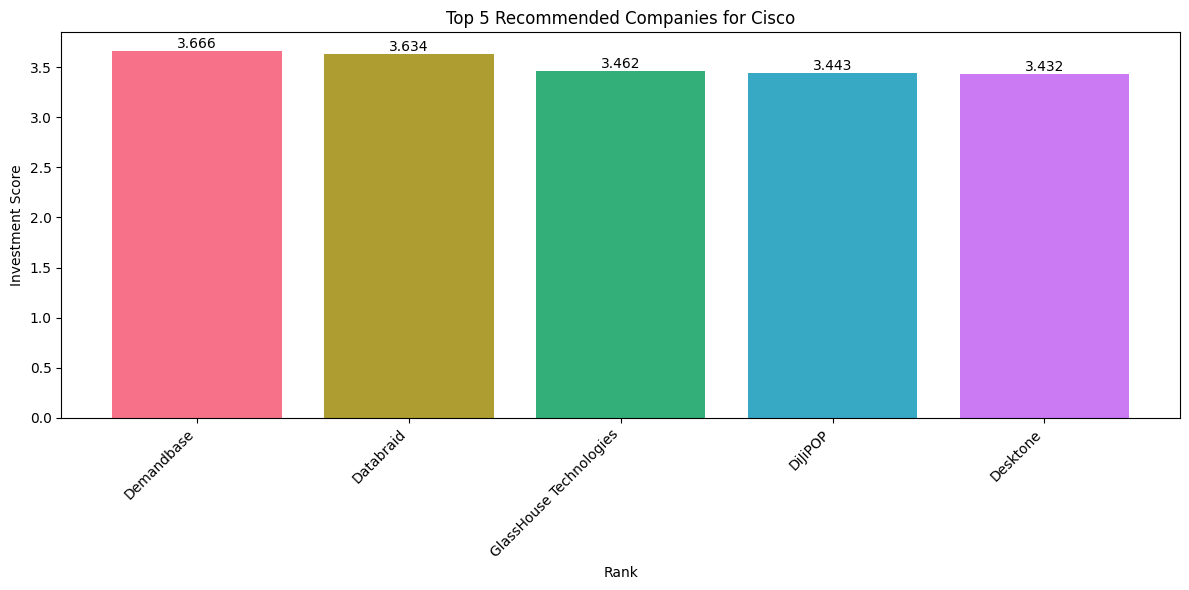


Top 5 Recommended Companies for Cisco:
1. Demandbase: 3.6660
2. Databraid: 3.6335
3. GlassHouse Technologies: 3.4617
4. DiJiPOP: 3.4433
5. Desktone: 3.4324


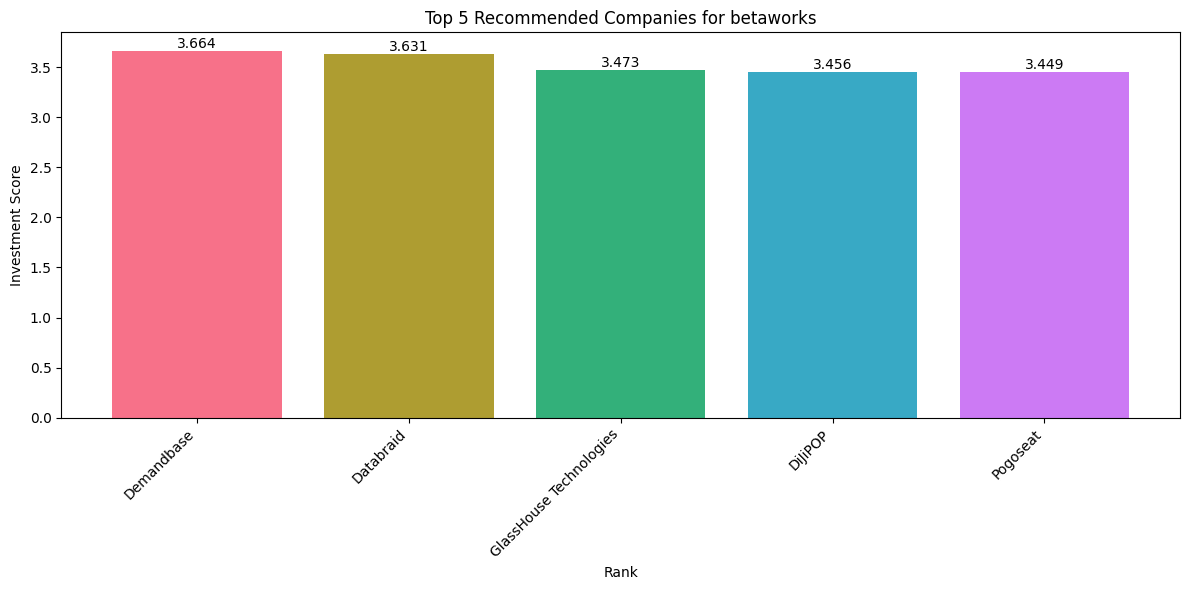


Top 5 Recommended Companies for betaworks:
1. Demandbase: 3.6641
2. Databraid: 3.6310
3. GlassHouse Technologies: 3.4728
4. DiJiPOP: 3.4559
5. Pogoseat: 3.4490


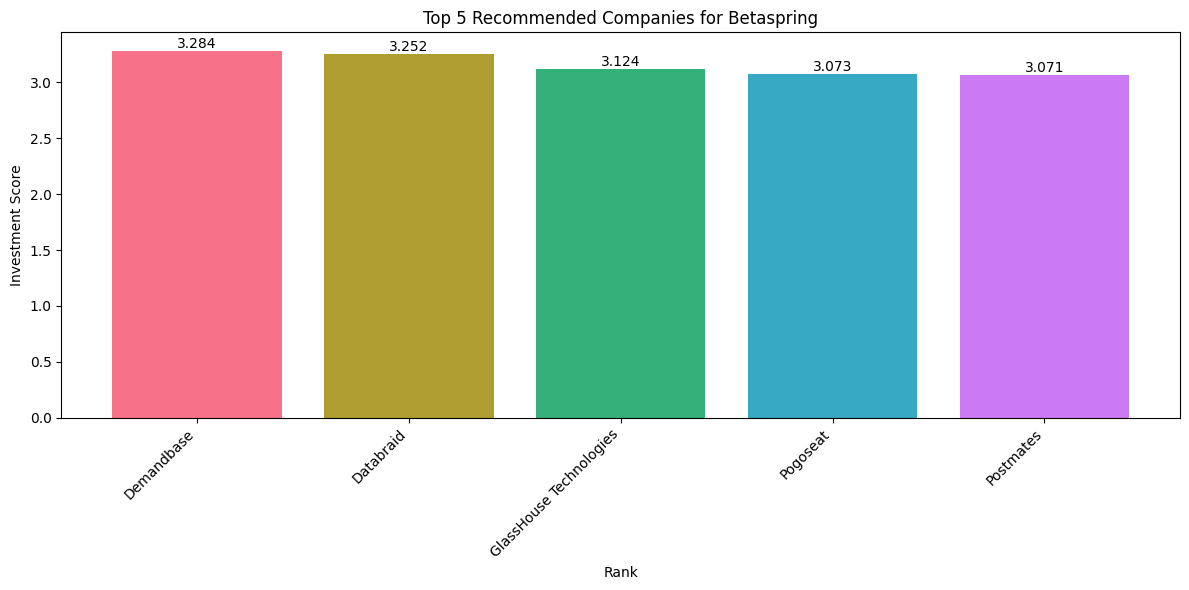


Top 5 Recommended Companies for Betaspring:
1. Demandbase: 3.2844
2. Databraid: 3.2525
3. GlassHouse Technologies: 3.1238
4. Pogoseat: 3.0734
5. Postmates: 3.0712


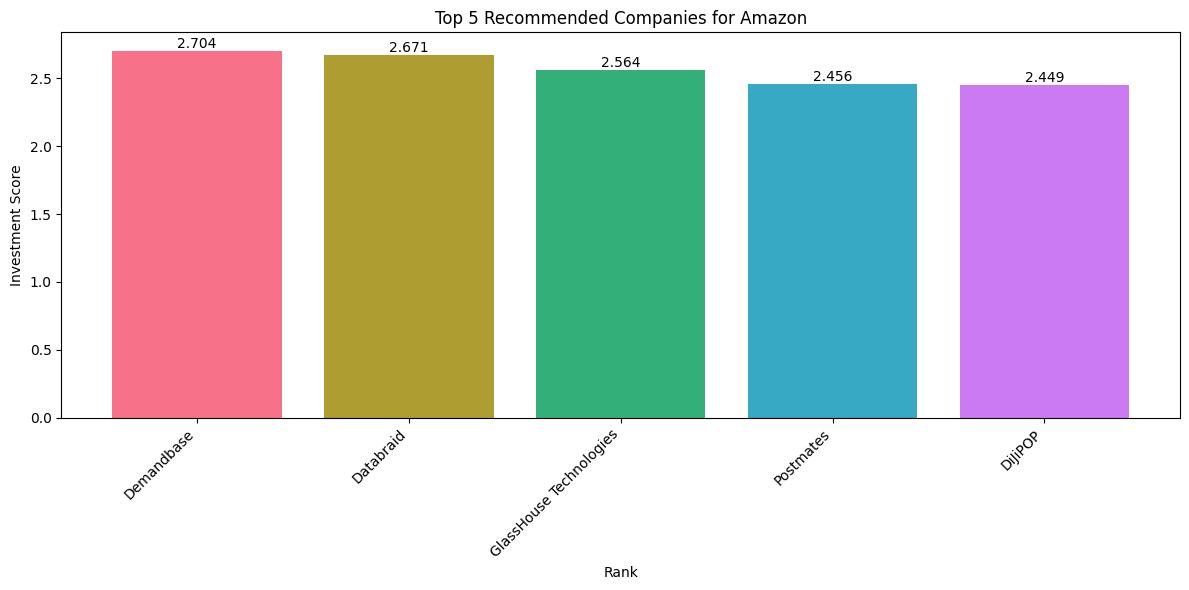


Top 5 Recommended Companies for Amazon:
1. Demandbase: 2.7036
2. Databraid: 2.6713
3. GlassHouse Technologies: 2.5639
4. Postmates: 2.4559
5. DiJiPOP: 2.4488


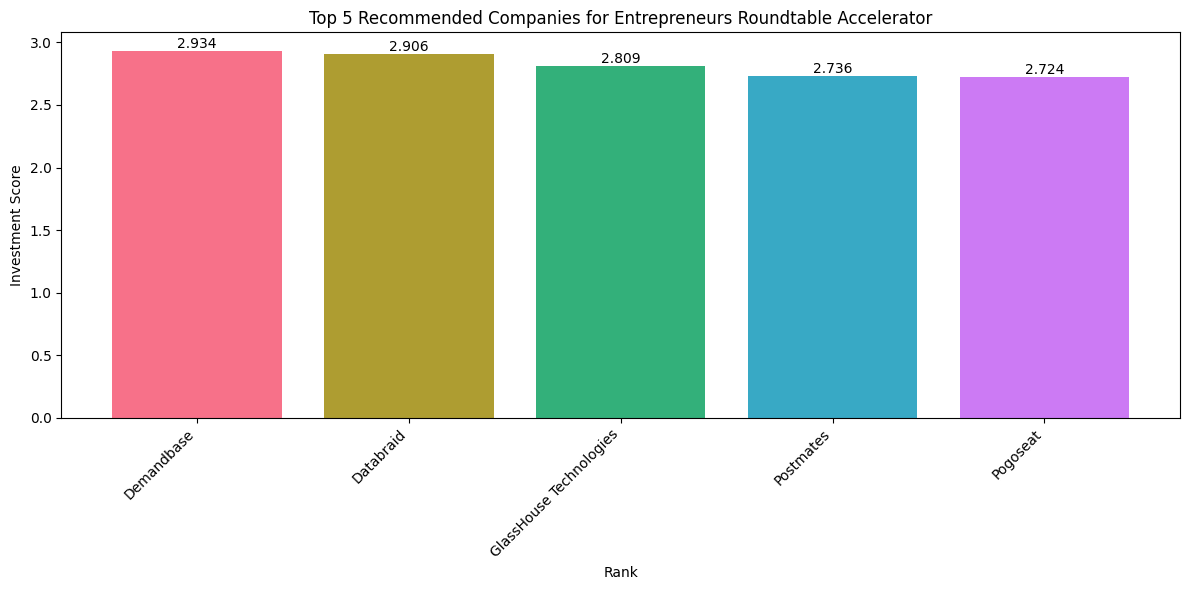


Top 5 Recommended Companies for Entrepreneurs Roundtable Accelerator:
1. Demandbase: 2.9340
2. Databraid: 2.9059
3. GlassHouse Technologies: 2.8087
4. Postmates: 2.7356
5. Pogoseat: 2.7243


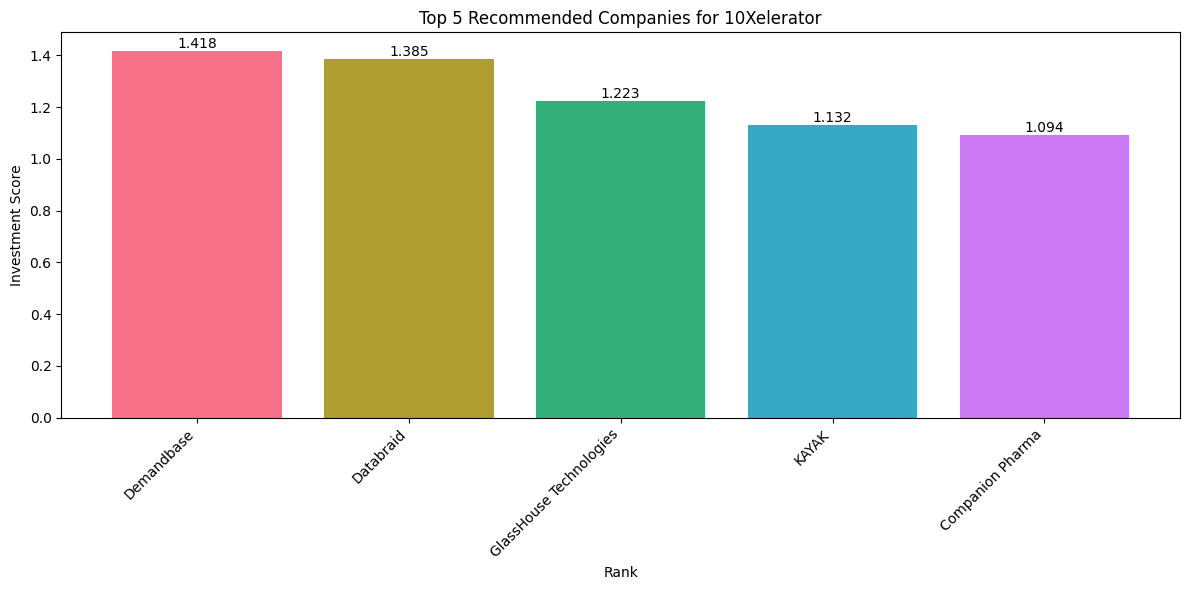


Top 5 Recommended Companies for 10Xelerator:
1. Demandbase: 1.4176
2. Databraid: 1.3849
3. GlassHouse Technologies: 1.2233
4. KAYAK: 1.1320
5. Companion Pharma: 1.0936


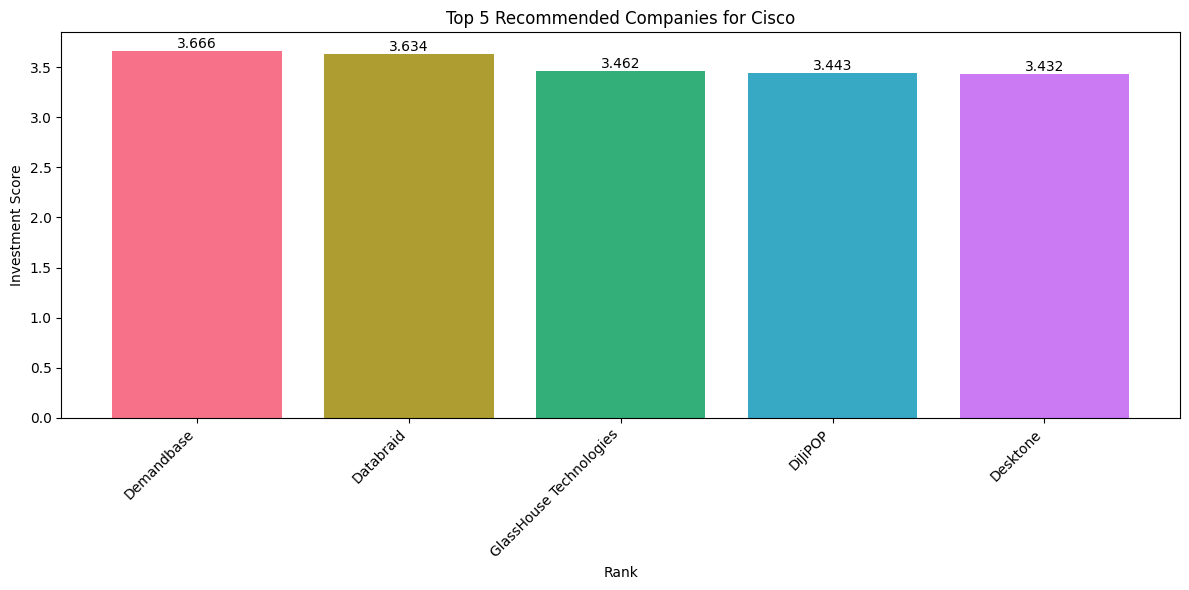


Top 5 Recommended Companies for Cisco:
1. Demandbase: 3.6660
2. Databraid: 3.6335
3. GlassHouse Technologies: 3.4617
4. DiJiPOP: 3.4433
5. Desktone: 3.4324


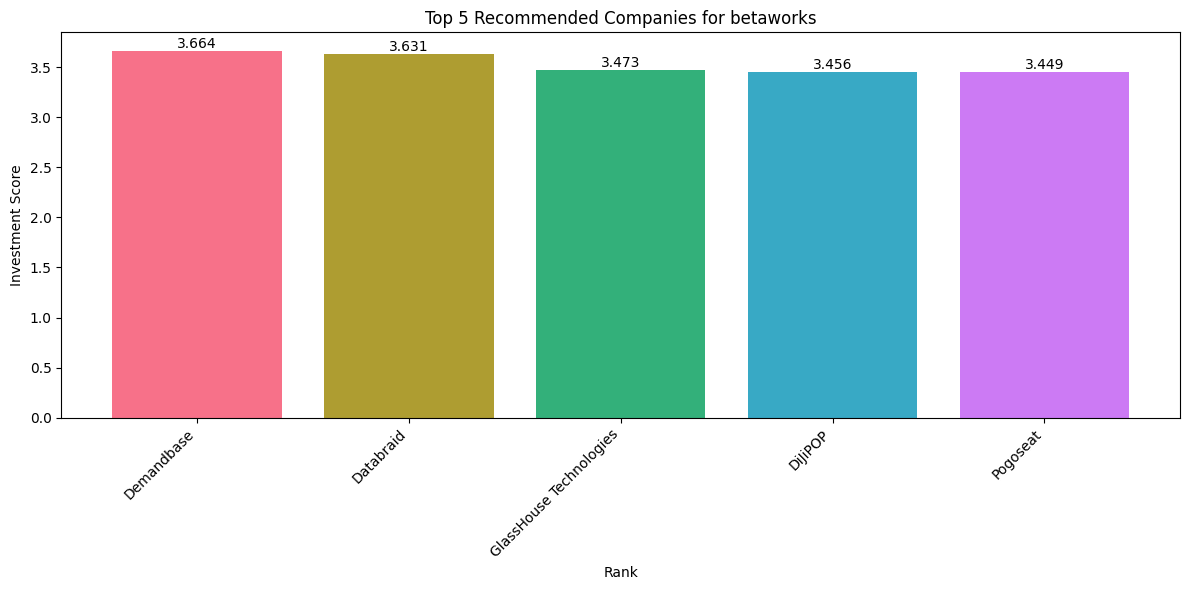


Top 5 Recommended Companies for betaworks:
1. Demandbase: 3.6641
2. Databraid: 3.6310
3. GlassHouse Technologies: 3.4728
4. DiJiPOP: 3.4559
5. Pogoseat: 3.4490


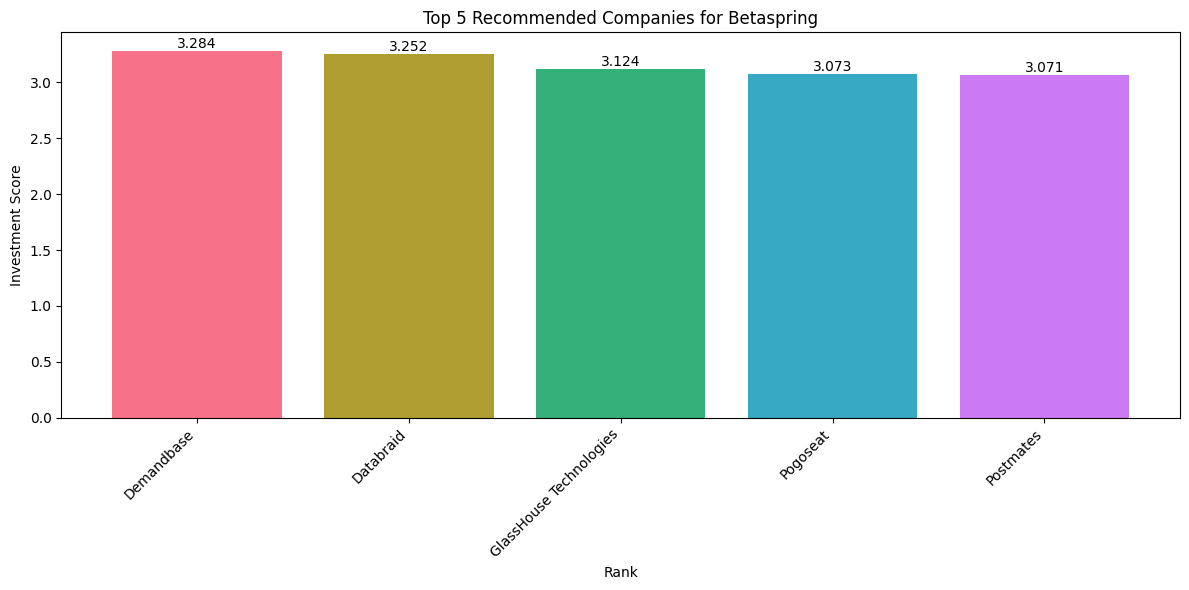


Top 5 Recommended Companies for Betaspring:
1. Demandbase: 3.2844
2. Databraid: 3.2525
3. GlassHouse Technologies: 3.1238
4. Pogoseat: 3.0734
5. Postmates: 3.0712


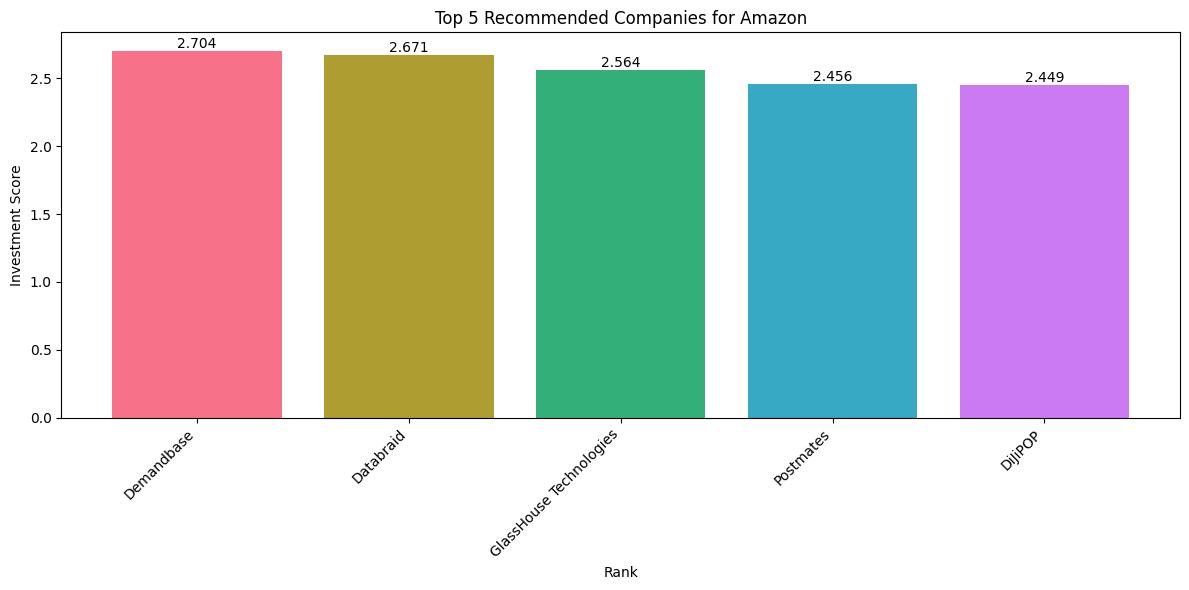


Top 5 Recommended Companies for Amazon:
1. Demandbase: 2.7036
2. Databraid: 2.6713
3. GlassHouse Technologies: 2.5639
4. Postmates: 2.4559
5. DiJiPOP: 2.4488


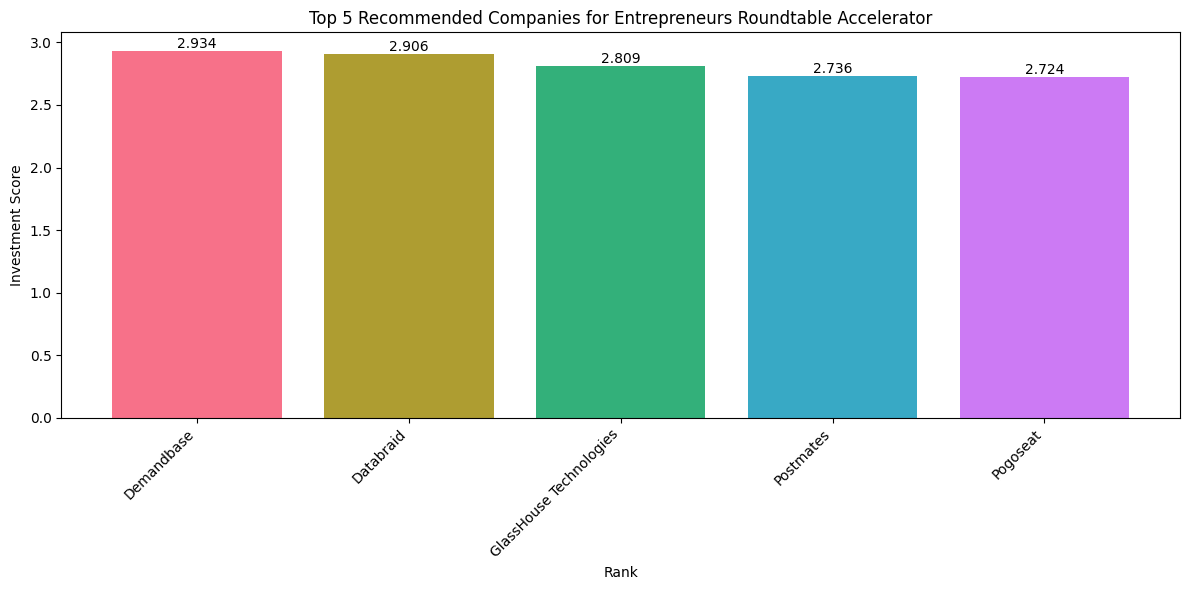


Top 5 Recommended Companies for Entrepreneurs Roundtable Accelerator:
1. Demandbase: 2.9340
2. Databraid: 2.9059
3. GlassHouse Technologies: 2.8087
4. Postmates: 2.7356
5. Pogoseat: 2.7243


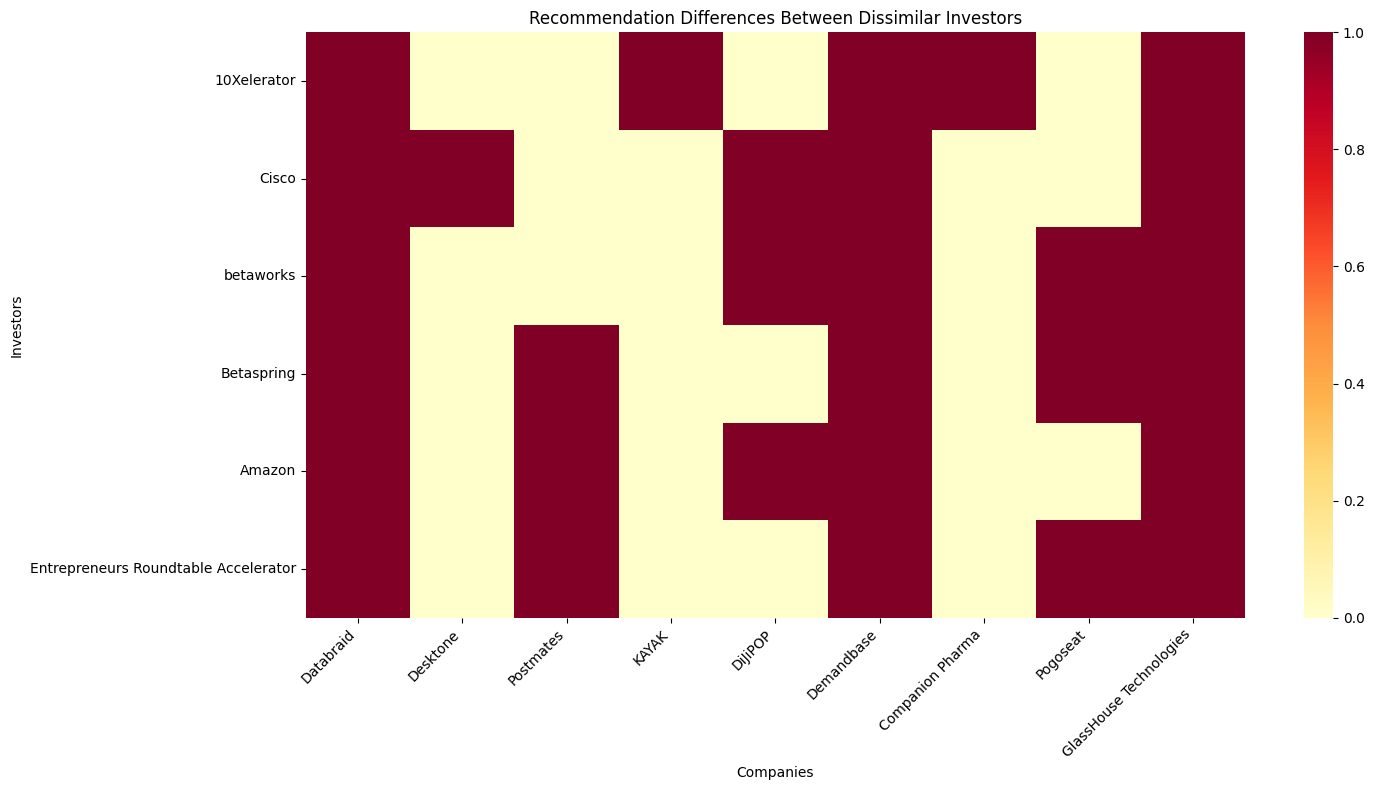

(array(['Demandbase', 'Databraid', 'GlassHouse Technologies', 'KAYAK',
        'Companion Pharma'], dtype=object),
 [('Cisco', 1.7604730129241943),
  ('betaworks', 1.7497212290763855),
  ('Betaspring', 1.6738885045051575),
  ('Amazon', 1.642804205417633),
  ('Entrepreneurs Roundtable Accelerator', 1.5009611248970032)])

In [ ]:
def find_dissimilar_investors(model, target_investor_name, num_dissimilar=5):
    """
    Find dissimilar investors based on their embedding patterns
    """
    try:
        # Get investor embeddings from the model
        investor_embedding_layer = model.get_layer('Investor_Embedding')
        all_investor_embeddings = investor_embedding_layer.get_weights()[0]

        # Get target investor embedding
        target_id = investor_encoder.transform([target_investor_name])[0]
        target_embedding = all_investor_embeddings[target_id]

        # Calculate cosine similarity with all investors
        dissimilarities = []
        for i, embedding in enumerate(all_investor_embeddings):
            if i != target_id:  # Skip the target investor
                similarity = np.dot(target_embedding, embedding) / (
                    np.linalg.norm(target_embedding) * np.linalg.norm(embedding)
                )
                # Convert similarity to dissimilarity
                dissimilarity = 1 - similarity
                dissimilarities.append((i, dissimilarity))

        # Sort by dissimilarity and get most dissimilar investors
        dissimilar_investors = sorted(dissimilarities, key=lambda x: x[1], reverse=True)[:num_dissimilar]

        return [(investor_encoder.inverse_transform([idx])[0], dis) for idx, dis in dissimilar_investors]

    except Exception as e:
        print(f"Error finding dissimilar investors: {e}")
        return []

def compare_dissimilar_recommendations(model, target_investor, dissimilar_investors, top_n=5):
    """
    Compare recommendations between target investor and dissimilar investors
    """
    try:
        # Get recommendations for target investor
        target_recs, target_scores = visualize_recommendations(model, target_investor, top_n)

        print(f"\n=== Recommendation Comparison (Dissimilar Investors) ===")
        print(f"\nTarget Investor: {target_investor}")
        print("Top Recommendations:")
        for company, score in zip(target_recs, target_scores):
            print(f"  {company}: {score:.4f}")

        # Get recommendations for dissimilar investors
        print("\nDissimilar Investors and Their Recommendations:")
        for investor, dissimilarity in dissimilar_investors:
            print(f"\n{investor} (Dissimilarity: {dissimilarity:.4f})")
            recs, scores = visualize_recommendations(model, investor, top_n)

            # Find different recommendations
            different_recs = set(recs) - set(target_recs)
            if different_recs:
                print("Unique recommendations:")
                for company in different_recs:
                    print(f"  {company}")
            else:
                print("No unique recommendations")

        # Visualize recommendation differences
        plt.figure(figsize=(12, 6))

        # Create a set of all unique companies
        all_companies = set(target_recs)
        for investor, _ in dissimilar_investors:
            recs, _ = visualize_recommendations(model, investor, top_n)
            all_companies.update(recs)

        # Create matrix of recommendations
        investors = [target_investor] + [inv for inv, _ in dissimilar_investors]
        recommendation_matrix = np.zeros((len(investors), len(all_companies)))

        for i, investor in enumerate(investors):
            recs, _ = visualize_recommendations(model, investor, top_n)
            for j, company in enumerate(all_companies):
                if company in recs:
                    recommendation_matrix[i, j] = 1

        # Plot heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(recommendation_matrix,
                   xticklabels=list(all_companies),
                   yticklabels=investors,
                   cmap='YlOrRd')
        plt.title('Recommendation Differences Between Dissimilar Investors')
        plt.xlabel('Companies')
        plt.ylabel('Investors')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return target_recs, dissimilar_investors

    except Exception as e:
        print(f"Error comparing recommendations: {e}")
        return None, None

# Example usage
investor_name = investor_encoder.classes_[0]  # Use first investor as example
dissimilar_investors = find_dissimilar_investors(model, investor_name)
compare_dissimilar_recommendations(model, investor_name, dissimilar_investors)

<ipython-input-19-a724d9a38815>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='raised_amount_usd', y='company_category_code', data=sector_funding, palette='coolwarm')


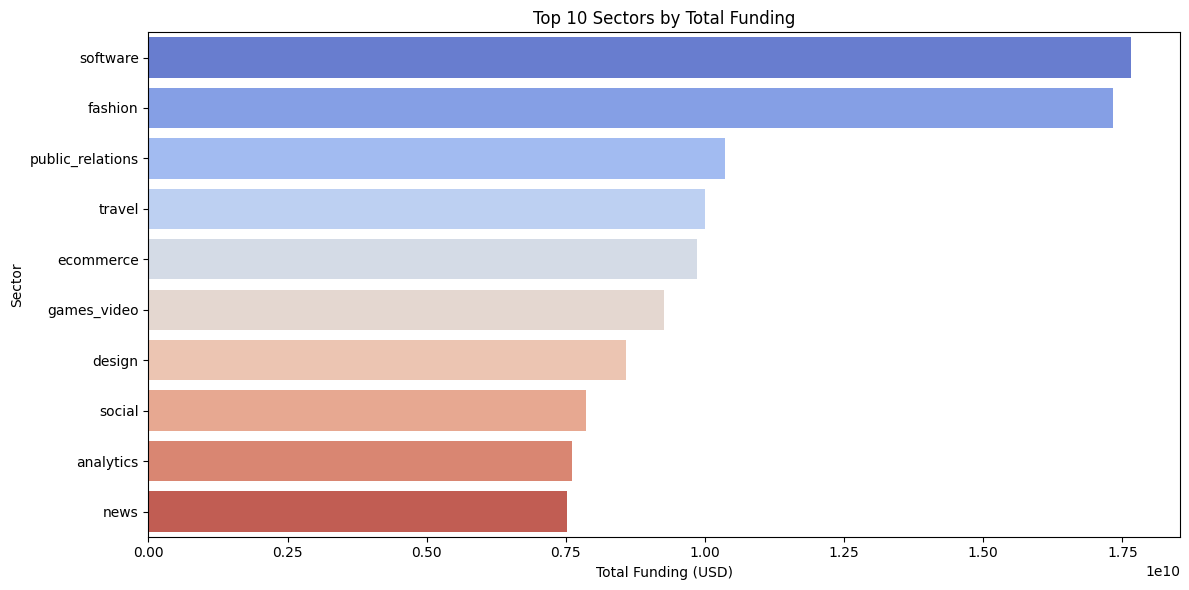

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate funding amounts by sector
sector_funding = df.groupby('company_category_code')['raised_amount_usd'].sum().reset_index()

# Sort by funding amount
sector_funding = sector_funding.sort_values(by='raised_amount_usd', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='raised_amount_usd', y='company_category_code', data=sector_funding, palette='coolwarm')
plt.title('Top 10 Sectors by Total Funding')
plt.xlabel('Total Funding (USD)')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()


<ipython-input-20-64f13ac78b76>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_investors.values, y=top_investors.index, palette='viridis')


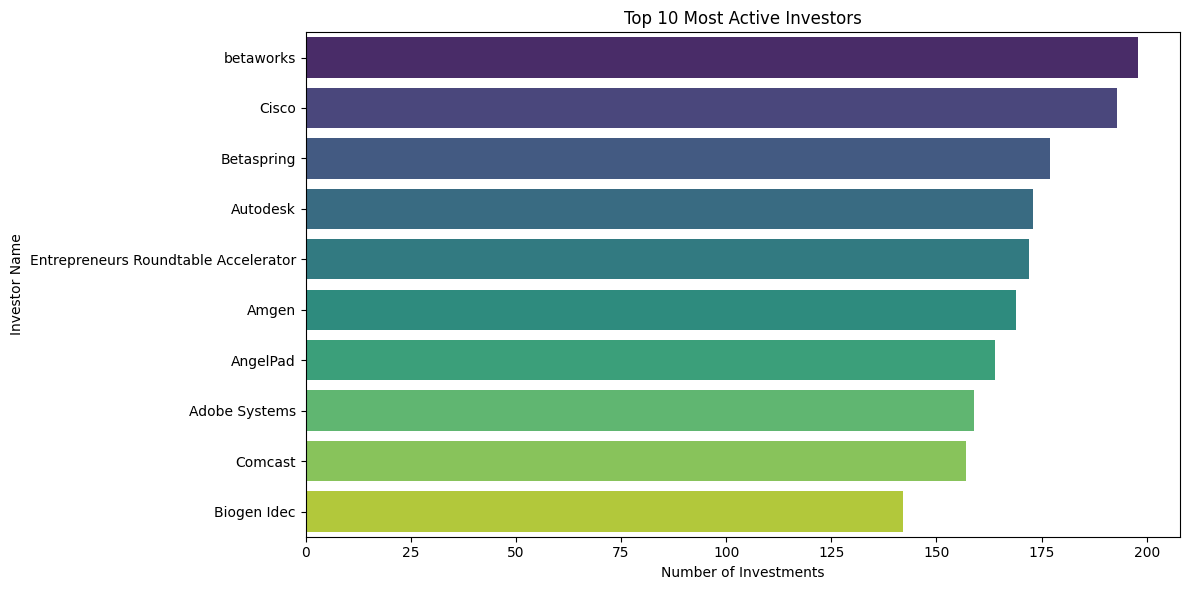

In [ ]:
# Top investors by number of investments
top_investors = df['investor_name'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_investors.values, y=top_investors.index, palette='viridis')
plt.title('Top 10 Most Active Investors')
plt.xlabel('Number of Investments')
plt.ylabel('Investor Name')
plt.tight_layout()
plt.show()


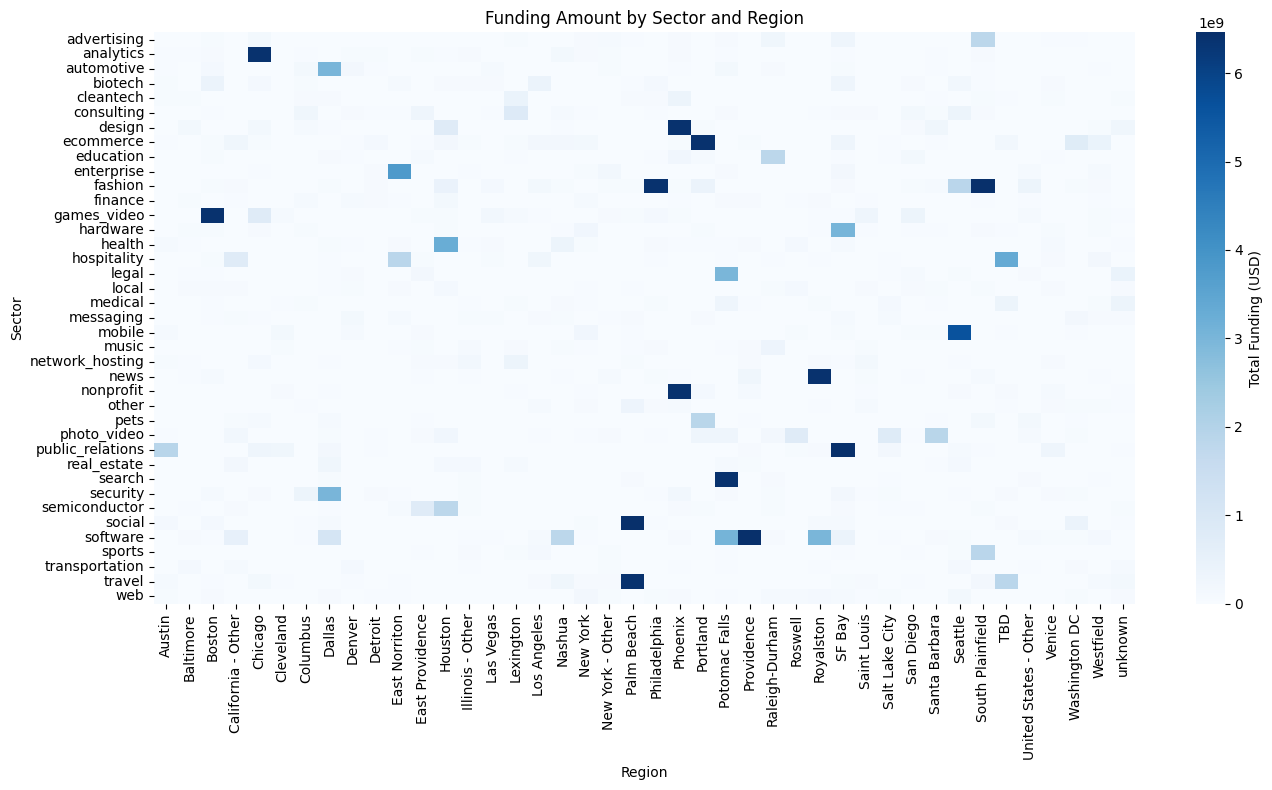

In [ ]:
# Create a pivot table for heatmap
heatmap_data = df.pivot_table(
    index='company_category_code',
    columns='company_region',
    values='raised_amount_usd',
    aggfunc='sum'
).fillna(0)

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt='.1f', cbar_kws={'label': 'Total Funding (USD)'})
plt.title('Funding Amount by Sector and Region')
plt.xlabel('Region')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()


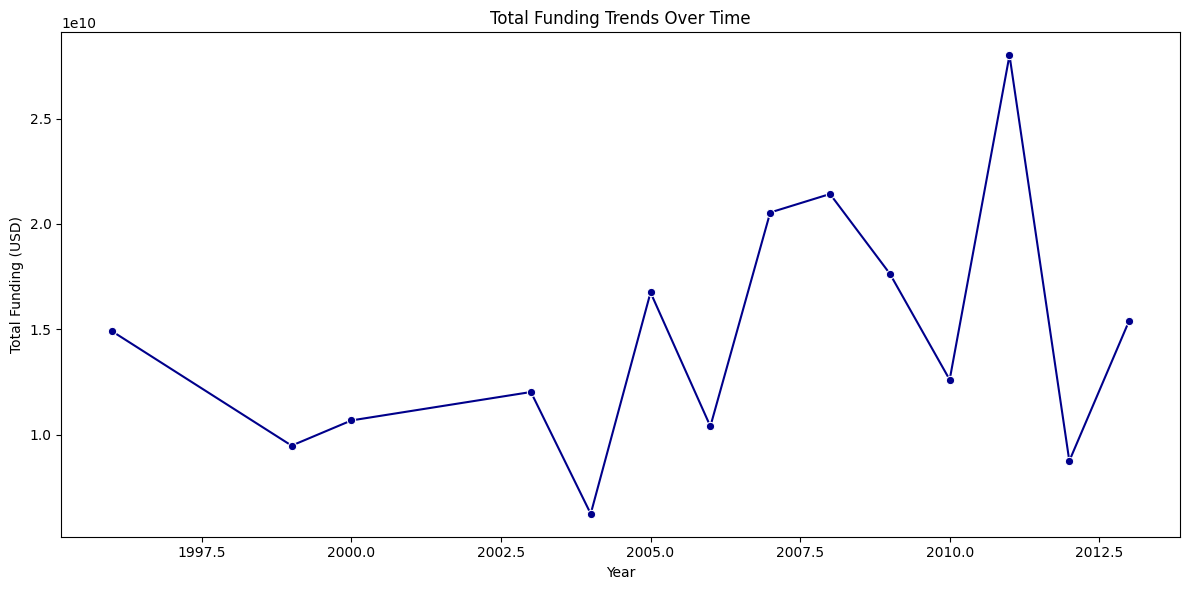

In [ ]:
# Aggregate funding by year
funding_trends = df.groupby('funded_year')['raised_amount_usd'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=funding_trends, x='funded_year', y='raised_amount_usd', marker='o', color='darkblue')
plt.title('Total Funding Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Total Funding (USD)')
plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


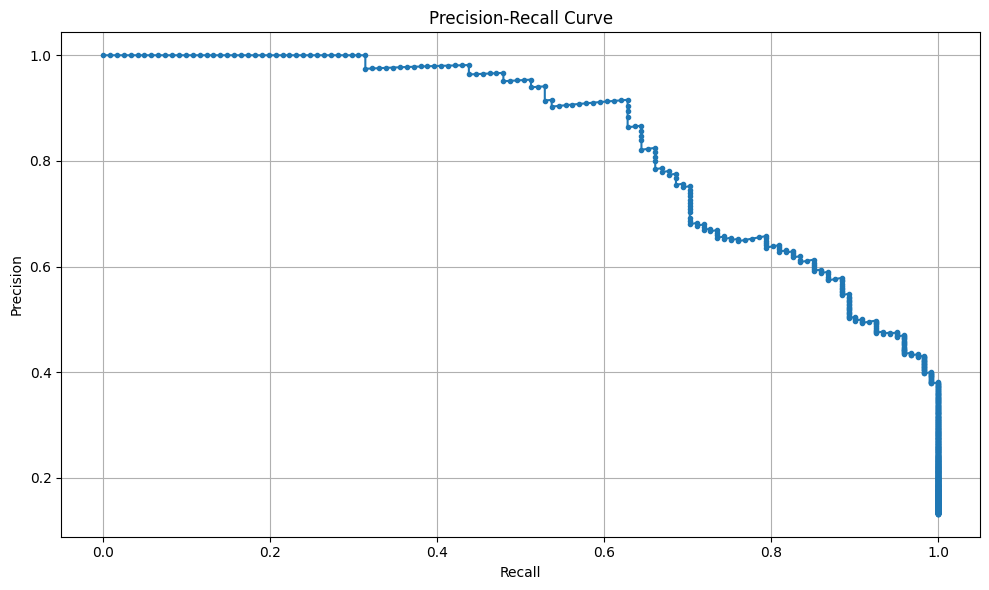

In [ ]:
from sklearn.metrics import precision_recall_curve

# Generate precision-recall data
y_pred = model.predict(X_test).flatten()
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.tight_layout()
plt.show()
